In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy
import mpl_toolkits.axisartist as axisartist
import torch
import clrnet
from analysis import feature_neuron_with_net
import seaborn as sns

In [2]:
plt.rcParams['savefig.dpi'] = 1000 #图片像素 
plt.rcParams['figure.dpi'] = 1000 #分辨率

In [3]:
results = np.load('./fig6/results.npy', allow_pickle=True)
# print(results)
results = results.ravel()[0]
spk = results['spk']
groups = results["groups"]
selected = results["selected"]
fmri = results["fmri"]
pred = results["pred"]
corr = results["corr"]
ami = results["ami"]
sil_tao = results["sil_tao"]
syn_score = results["syn_score"]
rate_score = results["rate_score"]
label = results["label"]
img = results["img"]
encoding = results["encoding"]
# color = results["color"]

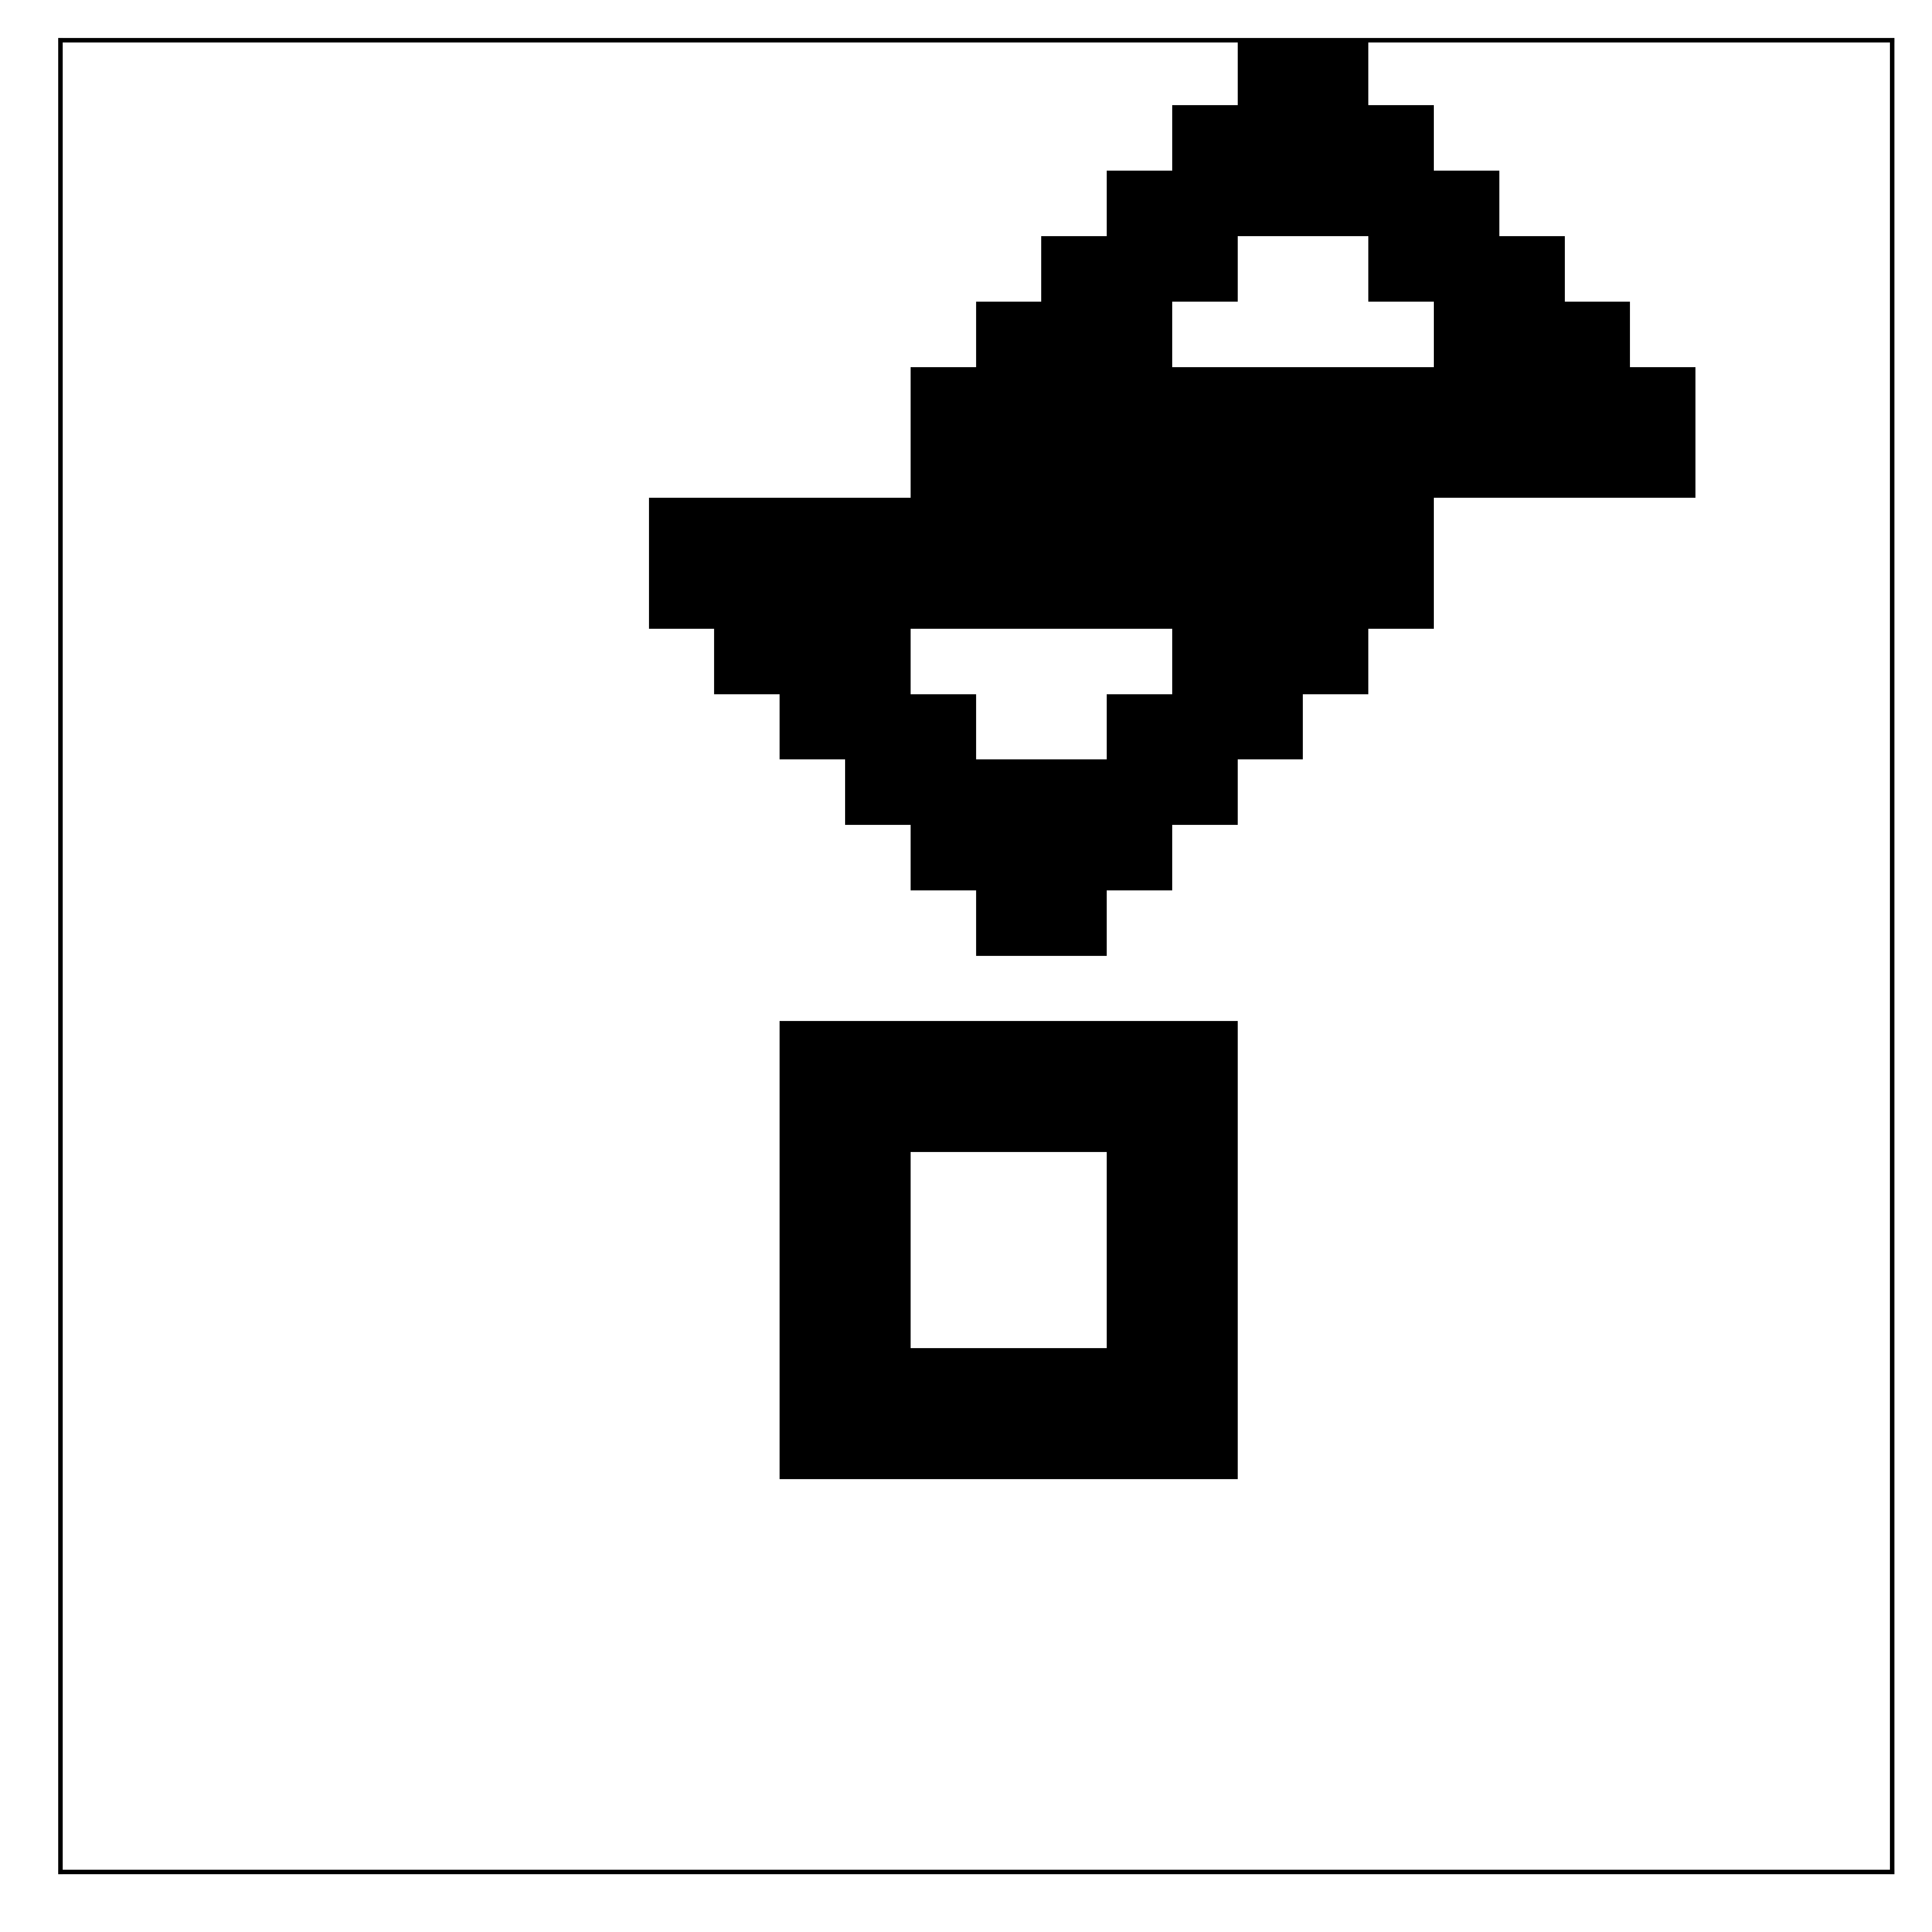

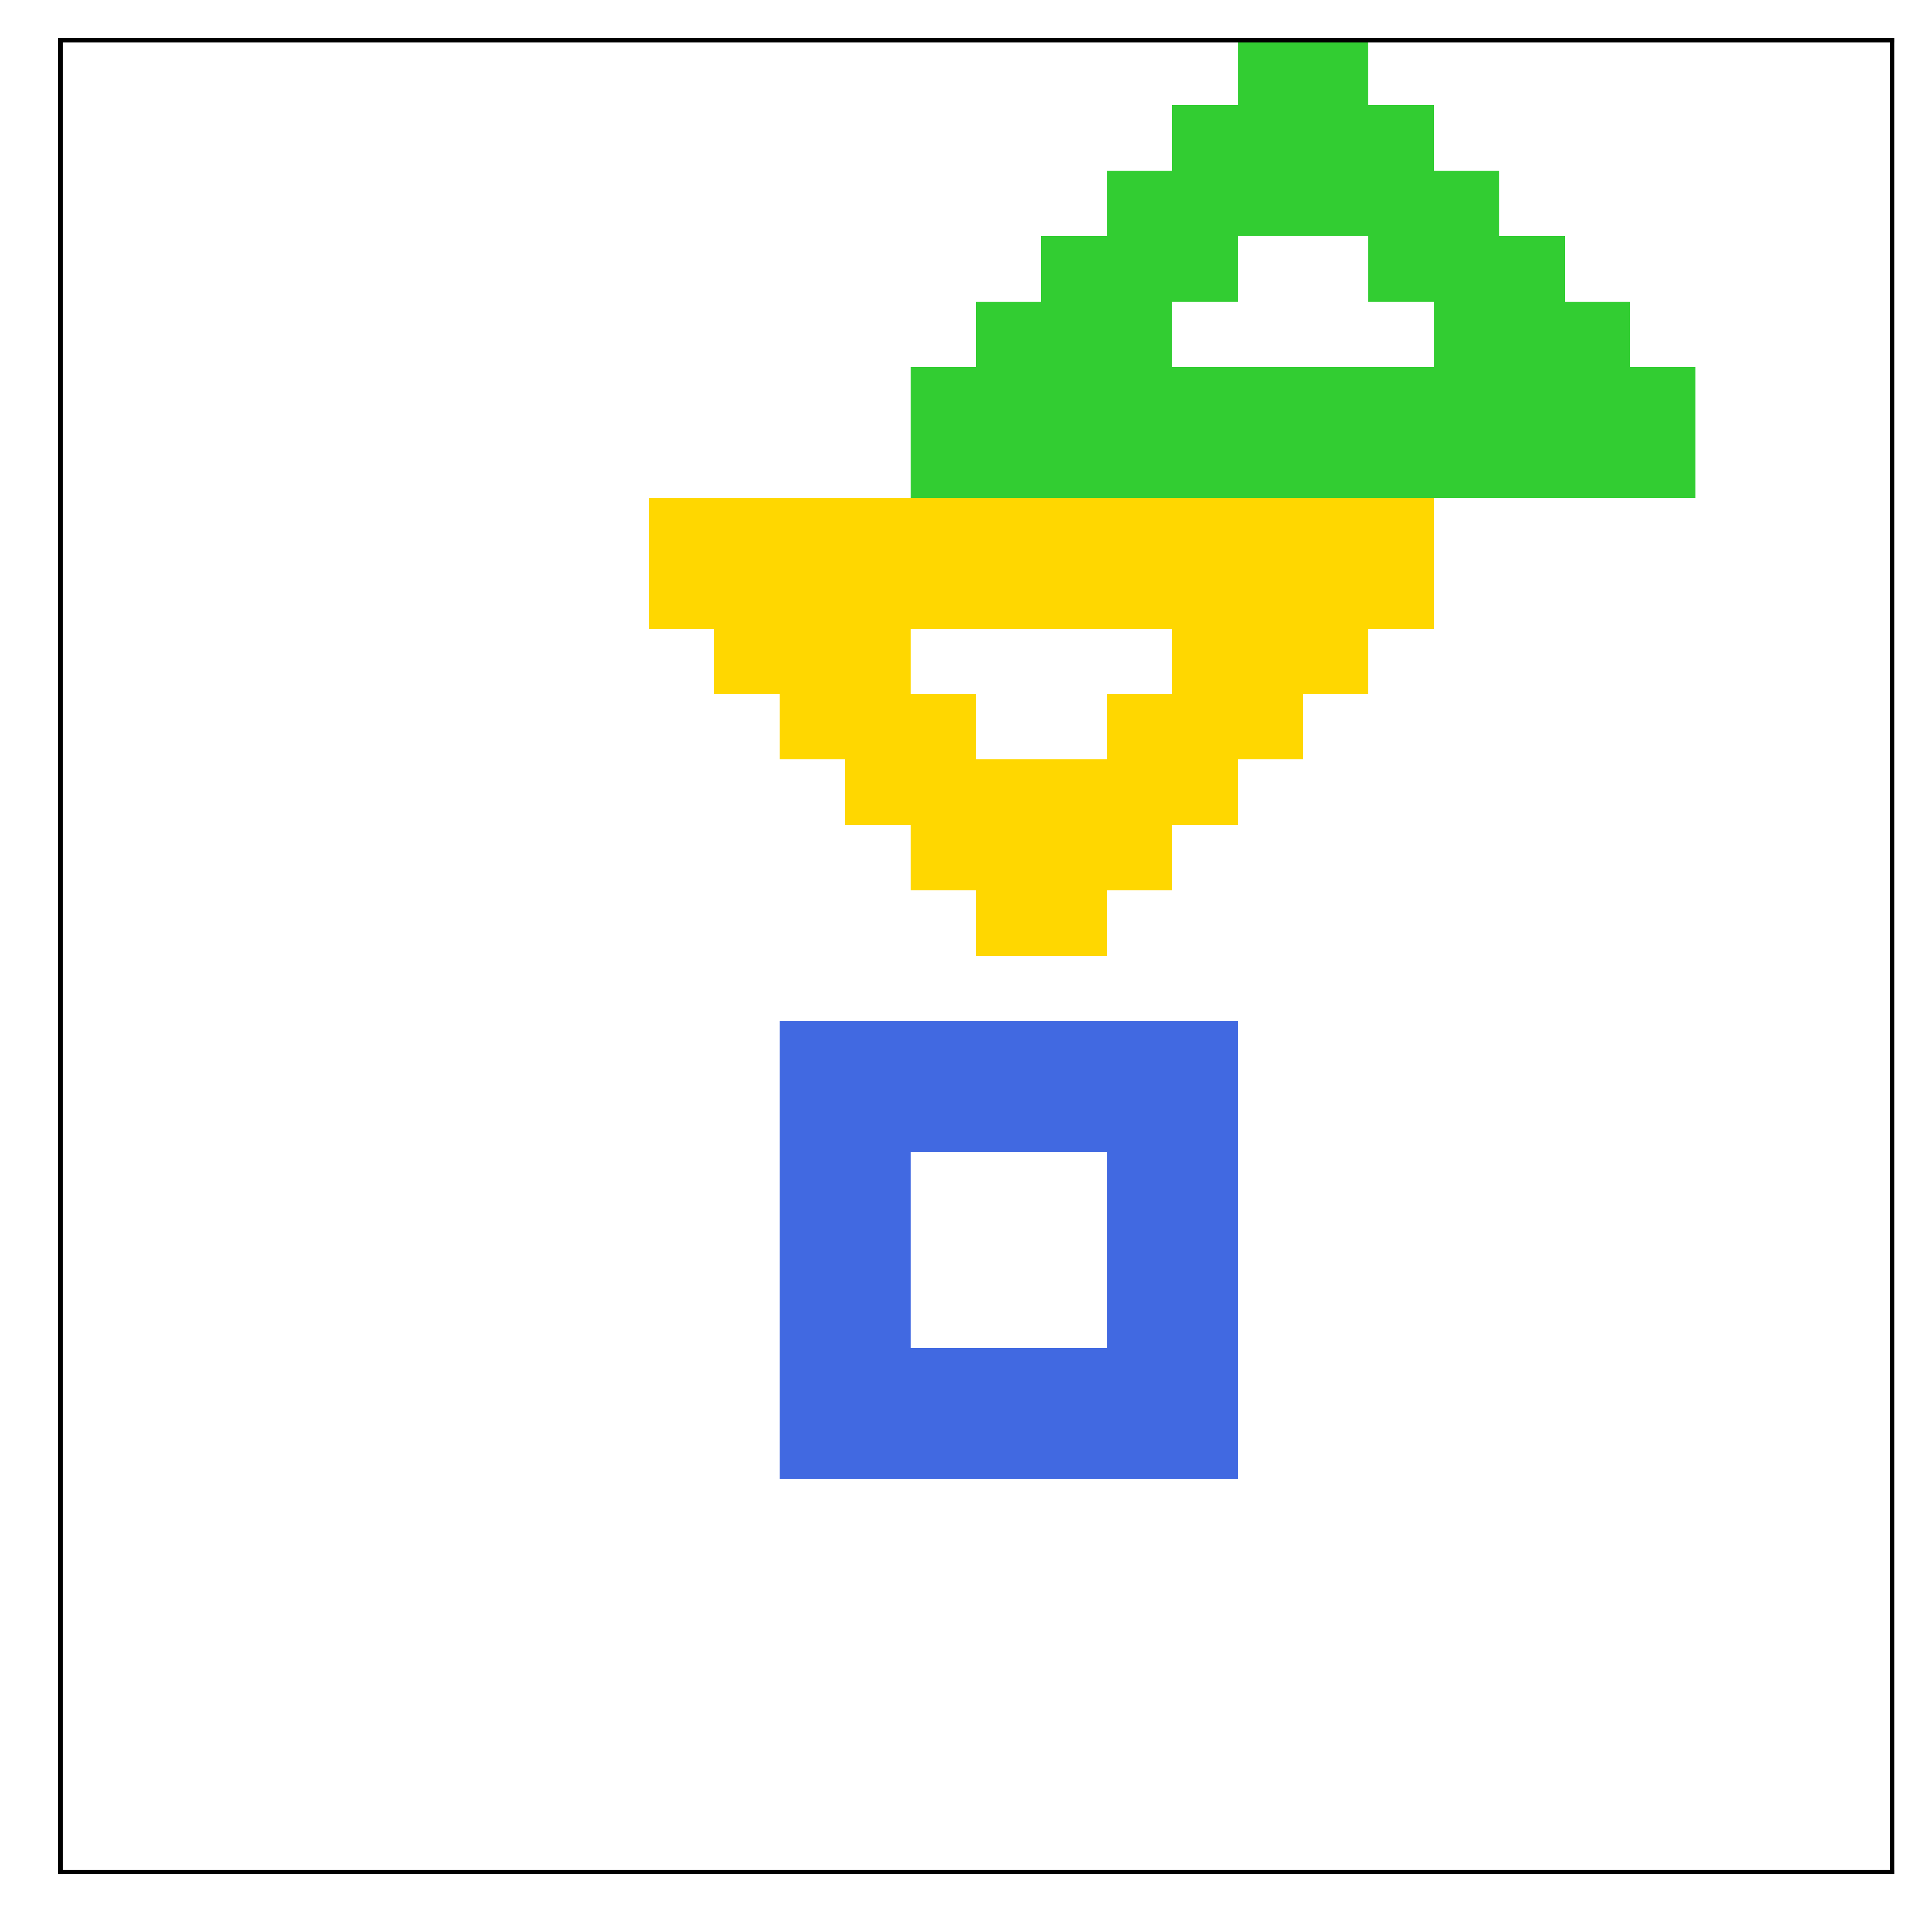

In [4]:
plt.rcParams['figure.figsize'] = (6.0, 6.0) # 单位是inches

plt.figure()
colors = ['white', 'black'] 
cmap = mpl.colors.ListedColormap(colors)
plt.imshow(img, cmap=cmap)
fig = plt.gca()
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
plt.show()

plt.figure()
colors = ['white', 'gold', 'royalblue', 'limegreen'] 
# colors = ['white', 'coral', 'forestgreen', 'powderblue']
cmap_obj = mpl.colors.ListedColormap(colors)
plt.imshow(label, cmap=cmap_obj)
# plt.imshow(label)
fig = plt.gca()
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)
plt.show()

## pattern可视化

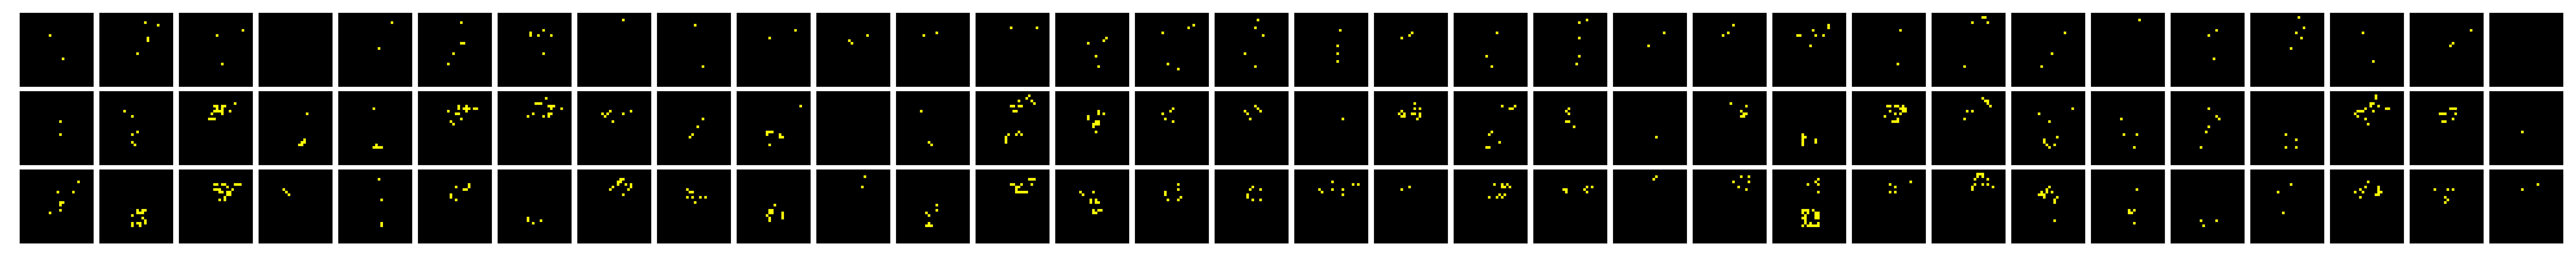

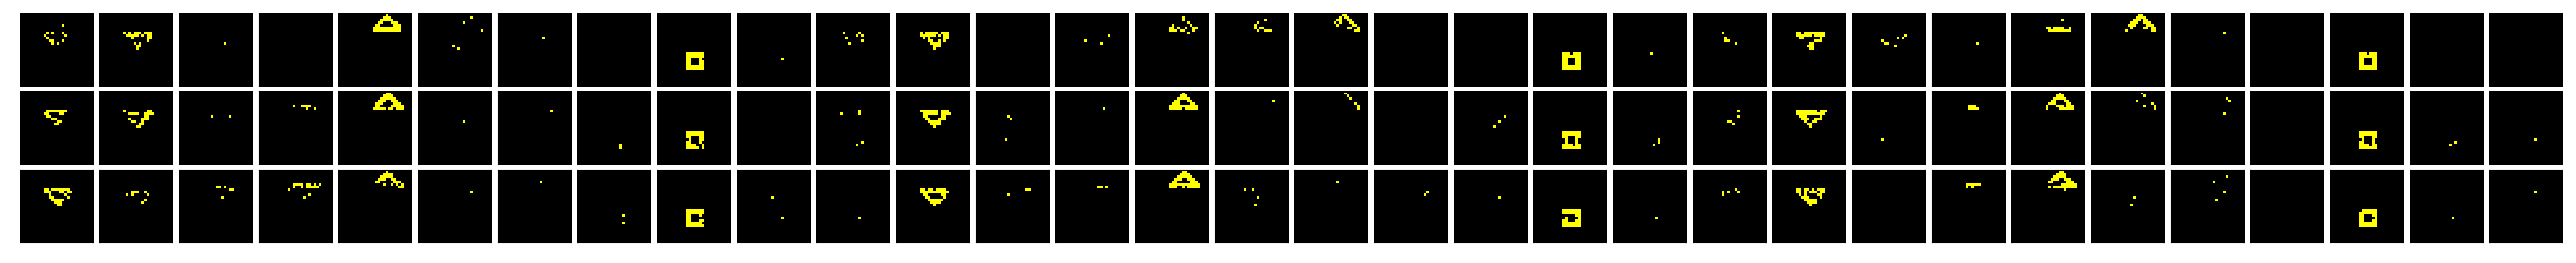

In [5]:
plt.rcParams['figure.figsize'] = (24.0, 3.0) # 单位是inches
def draw_spikes(spike_record, beg, end, name = ''):
    T = spike_record.shape[1]
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.1, hspace=0.05)  # 将高度和宽度百分比缩小到零
    for i in range(beg, end):
        for j in range(T):
            plt.subplot(end - beg + 1, T, (i - beg) * T + j + 1)
            #plt.subplot(8, 8, j + 1)
            # sns.heatmap(spike_record[i,j,:,:], square=True, cmap='viridis_r',
            #             xticklabels=False, yticklabels=False, cbar=False)
            colors = ['black', 'yellow'] 
            cmap = mpl.colors.ListedColormap(colors)
            plt.imshow(spike_record[i, j, :, :], cmap=cmap)
            plt.axis('on')
            plt.box('on')
            frame = plt.gca()
            
            frame.axes.get_yaxis().set_visible(False)
            frame.axes.get_xaxis().set_visible(False)
#             plt.tight_layout()
            
    plt.show()
    # plt.savefig('./fig4/')

for i in range(1):
    sz = spk[i].shape[0]
    draw_spikes(spk[i], beg=0, end=3)
    draw_spikes(spk[i], beg=sz-3, end=sz)

In [7]:
plt.rcParams['figure.figsize'] = (12.0, 12.0) # 单位是inches
cur_fmri = fmri[0]
sns.heatmap(cur_fmri, square=True, xticklabels=False,
                yticklabels=False, cmap='jet', cbar=True, cbar_kws={"shrink": 0.8})
# plt.imshow(cur_fmri)
# plt.colorbar(fraction=0.046, pad=0.17, cmap="jet")
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = torch.load('../tmp_net/shape_clrnet_spikes_batch_net4.pty').to(device)
# TODO 每次运行需要解注释
sp_sum_record = feature_neuron_with_net(net, (40, 40), -0.5, 0.5)

finding feature neurons in shapes net
torch.Size([28, 28])
20000
20000
20000


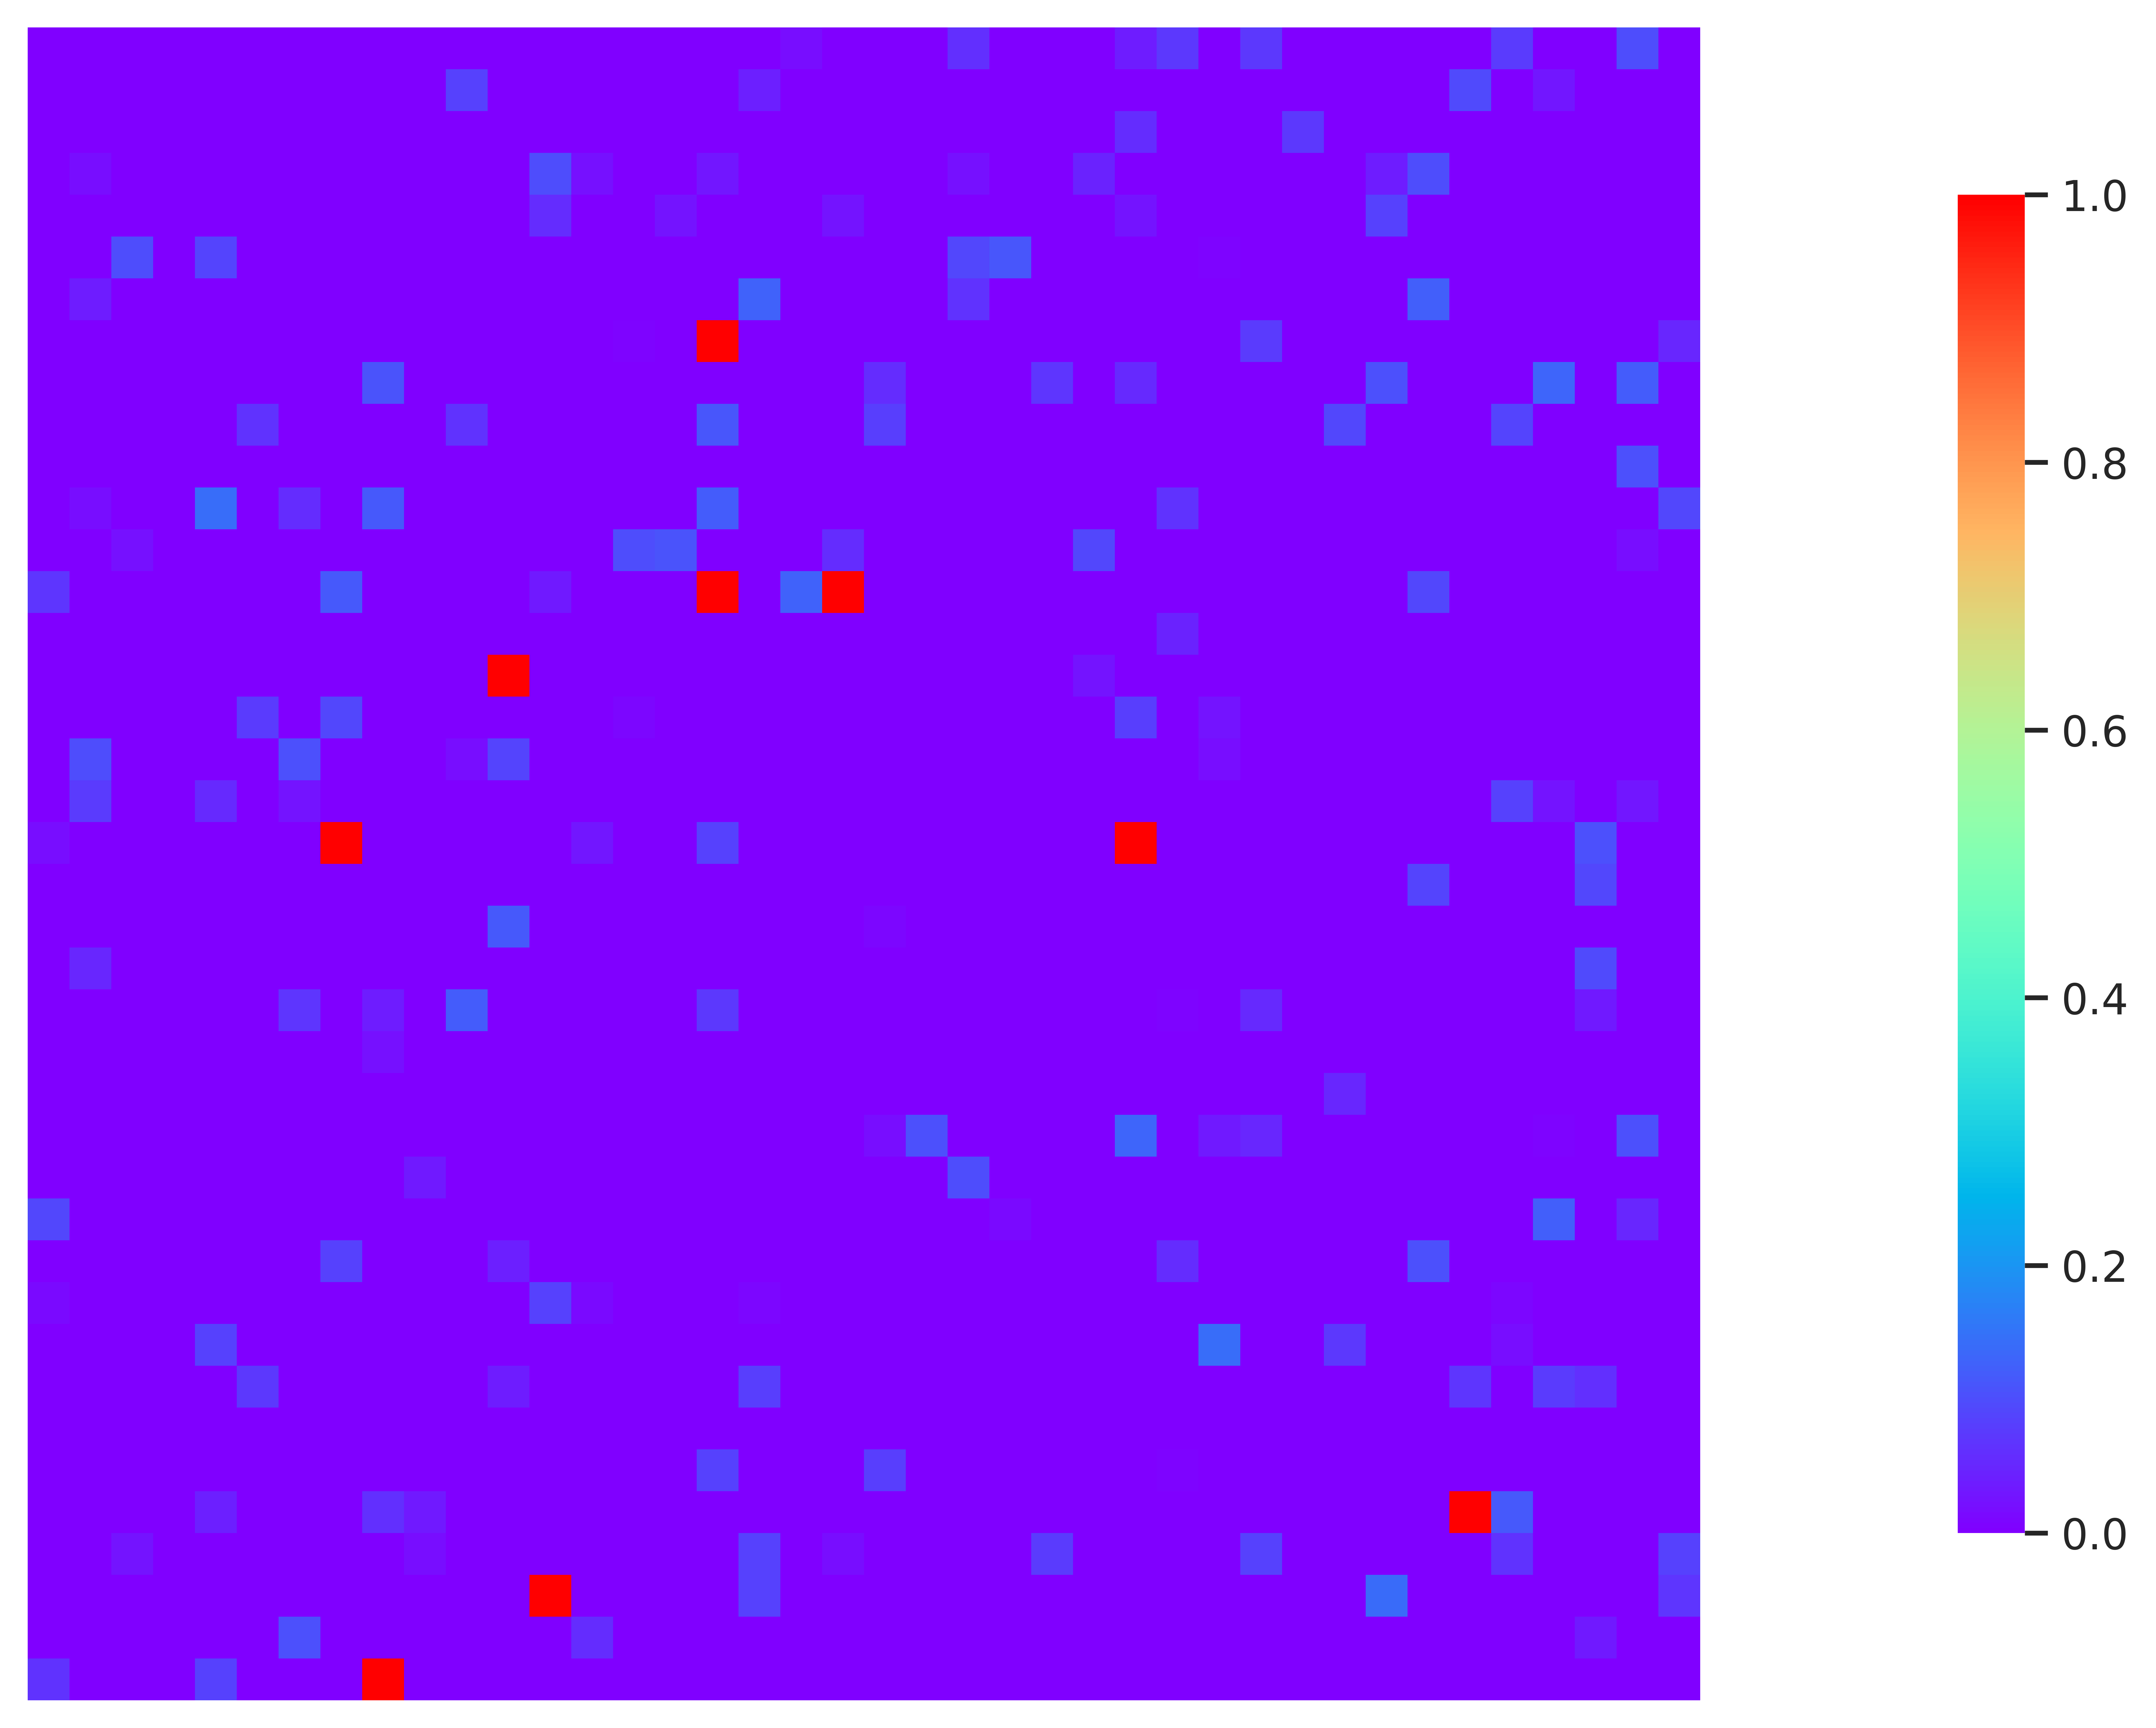

In [9]:
plt.rcParams['figure.figsize'] = (24.0, 8.0) # 单位是inches
plt.figure()
for sp in range(3):
    plt.subplot(1, 3, sp + 1)
    sns.heatmap(sp_sum_record[sp], square=True, xticklabels=False,
                yticklabels=False, cmap='rainbow', cbar=False, vmin=0, vmax=1)

    plt.axis('off')
plt.show()
sns.heatmap(sp_sum_record[sp], square=True, xticklabels=False,
                yticklabels=False, cmap='rainbow', cbar=True, cbar_kws={"shrink": 0.8}, vmin=0, vmax=1)
plt.show()

In [10]:
plt.rcParams['figure.figsize'] = (12.0, 8.0) # 单位是inches
plt.figure()
tmp_sp_sum_record = copy.deepcopy(sp_sum_record)
tmp_sp_sum_record = np.array(tmp_sp_sum_record)
tmp_sp_sum_record = -tmp_sp_sum_record.reshape(tmp_sp_sum_record.shape[0], -1)
tmp_sp_sum_record.sort(axis=1)
tmp_sp_sum_record = -tmp_sp_sum_record
for i in range(tmp_sp_sum_record.shape[0]):
    plt.plot(range(tmp_sp_sum_record.shape[1]), tmp_sp_sum_record[i])
plt.xlim([0, 100])
plt.ylabel('fire rate')
plt.xlabel('neuron')
plt.legend(['item1', 'item2', 'item3'])
plt.show()

# gain min value
thrd = np.zeros((tmp_sp_sum_record.shape[0], ))
top_k = np.zeros((tmp_sp_sum_record.shape[0], )).astype(np.int)
for i in range(tmp_sp_sum_record.shape[0]):
    pre = tmp_sp_sum_record[i, 0]
    for j in range(1, tmp_sp_sum_record.shape[1]):
        if tmp_sp_sum_record[i, j] < 0.9 * pre:
            thrd[i] = pre
            top_k[i] = j
            print('item %d has %d shape feature neuron' % (i, j))
            break
        else:
            pre = tmp_sp_sum_record[i, j]

item 0 has 20 shape feature neuron
item 1 has 5 shape feature neuron
item 2 has 9 shape feature neuron


In [11]:
print("top_k :", top_k)
idxes = []
feature_hidden_spikes = []
print(len(sp_sum_record))
sp_sum_record = np.array([record.reshape(-1) for record in sp_sum_record])

print(sp_sum_record.shape)
for sp in range(3):
    idx = (-np.abs(sp_sum_record[sp])).argsort()[: (top_k[sp])]
    idx = np.sort(idx)
    idxes.append(idx)
    print('item {}\'s feature neuron: {}'.format(sp, idx))
    s = np.ones((top_k[sp],))
    feature_hidden_spikes.append(torch.tensor(s, dtype=torch.float32))
# print(idxes)

top_k : [20  5  9]
3
(3, 1600)
item 0's feature neuron: [   7   20   62  165  248  310  312  329  383  450  598  628  693  733
 1355 1394 1554 1555 1562 1567]
item 1's feature neuron: [ 630  793 1007 1128 1481]
item 2's feature neuron: [ 296  536  539  611  767  786 1434 1492 1568]


In [12]:
import os
import h5py
# find position feature neuron
def open_dataset(data_dir, name):
    """
    open dataset files.
    data_dir: directory to the dataset h5 files
    name: name of the data, eg: bars
    """
    filename = os.path.join(data_dir, name + '.h5')
    return h5py.File(filename, 'r')

def gain_verf_dataset(data_dir, name):
    if name == "shapes_with_pos":
        s = []
        pos = []
        with open_dataset(data_dir, name) as f:
            s0 = f["train_single_0"]["default"][:]
            s1 = f["train_single_1"]["default"][:]
            s2 = f["train_single_2"]["default"][:]
            s.append(s0)
            s.append(s1)
            s.append(s2)
            s0 = f["train_single_0"]["pos"][:]
            s1 = f["train_single_1"]["pos"][:]
            s2 = f["train_single_2"]["pos"][:]
            pos.append(s0)
            pos.append(s1)
            pos.append(s2)
        return np.array(s), np.array(pos)
    else:
        print("not implemented!")

data, pos = gain_verf_dataset("../tmp_data", "shapes_with_pos")
pos = pos.astype(np.int)
print(data.shape)
print(pos.shape)

hidden_size = 1600
pos_size = img.shape[0]
pos_feature_neuron = np.zeros((pos_size, pos_size, hidden_size))
pos_data_num = np.ones((pos_size, pos_size))
net = torch.load('../tmp_net/shape_clrnet_spikes_batch_net4.pty').to(device)
batch_size = 500
for item in range(data.shape[0]):
    for i in range(0, data.shape[1], batch_size):
        X = torch.tensor(data[item, i:i+batch_size, :, :], dtype=torch.float32, device=device).reshape(batch_size, -1)
        Y, hidden, _ = net(X)
        if item == 0:
            pos_feature_neuron[pos[item, i:i+batch_size, 0], pos[item, i:i+batch_size, 1], :] += hidden.cpu().detach().numpy()
            pos_data_num[pos[item, i:i+batch_size, 0], pos[item, i:i+batch_size, 1]] += 1
        else:
            pos_feature_neuron[pos[item, i:i+batch_size, 0], pos[item, i:i+batch_size, 1], :] += hidden.cpu().detach().numpy()
            pos_data_num[pos[item, i:i+batch_size, 0], pos[item, i:i+batch_size, 1]] += 1

for i in range(pos_feature_neuron.shape[0]):
    for j in range(pos_feature_neuron.shape[1]):
        if pos_data_num[i, j] > 1:
            pos_data_num[i, j] -= 1
        pos_feature_neuron[i, j, :] /= pos_data_num[i, j]
print(pos_feature_neuron.shape)
# print(pos_feature_neuron[0, 22], pos_feature_neuron[10, 10])

(3, 60000, 28, 28)
(3, 60000, 2)
(28, 28, 1600)


In [13]:
pos_feature_neuron_tmp = copy.deepcopy(pos_feature_neuron)
plt.rcParams['figure.figsize'] = (12.0, 4.0) # 单位是inches
plt.figure()
pos_feature_neuron_tmp = pos_feature_neuron_tmp.reshape(-1, hidden_size)
pos_feature_neuron_tmp = - pos_feature_neuron_tmp
pos_feature_neuron_tmp.sort(axis=1)
pos_feature_neuron_tmp = - pos_feature_neuron_tmp
for i in range(pos_feature_neuron_tmp.shape[0]):
    plt.plot(range(pos_feature_neuron_tmp.shape[1]), pos_feature_neuron_tmp[i])
plt.xlim([0, 120])
plt.ylabel('fire rate')
plt.xlabel('neuron')
# plt.legend(['item1', 'item2', 'item3'])
plt.show()

# gain min value
thrd = np.zeros((pos_feature_neuron_tmp.shape[0], ))
top_k = np.zeros((pos_feature_neuron_tmp.shape[0], )).astype(np.int)
for i in range(pos_feature_neuron_tmp.shape[0]):
    pre = pos_feature_neuron_tmp[i, 1]
    thrd[i] = pre
    top_k[i] = j
    for j in range(2, pos_feature_neuron_tmp.shape[1]):
        if pos_feature_neuron_tmp[i, j] < 0.5 * pre:
            thrd[i] = pre
            top_k[i] = j
            print('item %d has %d shape feature neuron' % (i, j))
            break
        else:
            pre = pos_feature_neuron_tmp[i, j]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


item 0 has 69 shape feature neuron
item 1 has 82 shape feature neuron
item 2 has 84 shape feature neuron
item 3 has 78 shape feature neuron
item 4 has 82 shape feature neuron
item 5 has 85 shape feature neuron
item 6 has 95 shape feature neuron
item 7 has 83 shape feature neuron
item 8 has 93 shape feature neuron
item 9 has 77 shape feature neuron
item 10 has 87 shape feature neuron
item 11 has 81 shape feature neuron
item 12 has 85 shape feature neuron
item 13 has 76 shape feature neuron
item 14 has 79 shape feature neuron
item 15 has 87 shape feature neuron
item 16 has 79 shape feature neuron
item 17 has 45 shape feature neuron
item 18 has 51 shape feature neuron
item 19 has 48 shape feature neuron
item 20 has 53 shape feature neuron
item 21 has 51 shape feature neuron
item 28 has 66 shape feature neuron
item 29 has 82 shape feature neuron
item 30 has 83 shape feature neuron
item 31 has 83 shape feature neuron
item 32 has 69 shape feature neuron
item 33 has 77 shape feature neuron
it

In [14]:
# print("top_k :", top_k)
pos_idxes = []
pos_feature_hidden_spikes = []
pos_feature_neuron_tmp = copy.deepcopy(pos_feature_neuron)
pos_feature_neuron_tmp = pos_feature_neuron_tmp.reshape(-1, hidden_size)

print(sp_sum_record.shape)
for i in range(pos_feature_neuron_tmp.shape[0]):
    idx = (-np.abs(pos_feature_neuron_tmp[i])).argsort()[: (top_k[i])]
    idx = np.sort(idx)
    pos_idxes.append(idx)
    print('item {}\'s feature neuron: {}'.format(i, idx))
    s = np.ones((top_k[i],))
    pos_feature_hidden_spikes.append(torch.tensor(s, dtype=torch.float32))
# print(idxes)

(3, 1600)
item 0's feature neuron: [   7   20   57   62   74  165  186  192  196  241  248  252  257  296
  310  312  329  355  383  386  449  450  479  482  536  539  598  611
  630  693  733  758  763  767  773  786  793  862  876  924  926  933
  938  943 1007 1057 1064 1074 1120 1128 1204 1265 1271 1273 1291 1350
 1355 1394 1409 1434 1472 1481 1492 1554 1555 1562 1567 1568 1590]
item 1's feature neuron: [   7   20   30   57   62  118  119  165  186  196  210  241  248  252
  274  296  310  312  329  339  383  403  411  420  445  449  450  465
  479  536  539  598  611  628  630  693  708  733  758  767  786  793
  847  913  926  933  938  943  981 1007 1035 1057 1064 1074 1128 1172
 1181 1184 1204 1252 1271 1273 1291 1350 1355 1387 1394 1409 1434 1443
 1472 1481 1492 1517 1539 1554 1555 1562 1567 1568 1584 1590]
item 2's feature neuron: [   7    9   20   30   57   62  111  119  144  151  165  186  210  222
  248  296  310  312  317  329  332  369  383  391  403  411  437  449
  450

item 341's feature neuron: [   7   18   20   62   84  111  118  129  152  165  223  248  270  296
  310  312  317  329  339  340  346  369  383  395  444  450  478  511
  536  539  564  598  611  621  628  630  681  686  693  733  767  776
  781  786  793  797  875  907 1007 1030 1066 1078 1099 1128 1139 1171
 1177 1193 1252 1255 1310 1355 1394 1422 1434 1467 1478 1481 1488 1492
 1516 1554 1555 1562 1567 1568 1574]
item 342's feature neuron: [   7   18   20   62   84  106  118  129  165  181  223  248  274  296
  310  312  325  329  339  369  383  395  411  438  444  450  478  536
  538  539  564  598  611  628  630  650  681  686  693  733  735  767
  776  781  786  793  797  936  960 1007 1030 1050 1099 1128 1139 1167
 1177 1184 1193 1215 1252 1255 1310 1355 1368 1377 1394 1422 1434 1467
 1478 1481 1488 1492 1508 1516 1519 1554 1555 1562 1567 1568 1574]
item 343's feature neuron: [   7   17   18   20   62   84  106  118  151  165  181  248  257  274
  296  310  312  325  329  355  36

item 397's feature neuron: [   7   20   26   27   37   62  122  147  165  210  248  267  296  310
  312  329  340  353  383  411  449  450  494  533  536  539  587  598
  611  628  630  650  681  686  691  693  706  733  767  786  793  844
  870  924  936  960 1007 1030 1035 1045 1078 1088 1120 1128 1149 1330
 1350 1355 1360 1366 1394 1434 1481 1492 1503 1519 1554 1555 1560 1562
 1567 1568 1580]
item 398's feature neuron: [   7   20   27   62   82  118  144  147  151  165  175  210  228  248
  267  274  296  310  312  317  329  332  339  340  352  353  365  383
  411  414  444  449  450  458  465  494  533  536  539  544  554  590
  598  611  628  630  650  681  686  691  693  733  767  786  793  845
  847  882  920  936  943 1007 1030 1078 1099 1120 1128 1149 1172 1174
 1177 1181 1255 1265 1290 1350 1355 1365 1394 1434 1481 1492 1494 1554
 1555 1562 1567 1568 1572]
item 399's feature neuron: [   7   20   27   59   62   82  151  165  175  210  241  248  267  296
  310  312  317  329  3

(28, 28)
has shapes:  [1, 2, 0]
shapes position:  [[0, 13], [7, 9], [15, 11]]
[   7   17   20   22   62  106  144  151  165  196  210  248  264  296
  310  312  329  332  358  383  387  446  450  456  478  536  539  557
  598  611  628  630  693  721  732  733  758  767  786  793  833  870
  893  917  930  950 1007 1078 1088 1128 1143 1172 1232 1244 1290 1302
 1310 1311 1316 1321 1355 1390 1394 1422 1434 1443 1481 1488 1492 1554
 1555 1562 1567 1568 1584 1590]
[   7   20   50   56   57   62  108  147  151  165  210  248  257  296
  310  312  329  340  372  383  450  457  467  511  521  536  539  598
  611  628  630  634  693  706  733  758  767  779  786  793  833  862
  920  984 1000 1007 1050 1061 1088 1128 1156 1255 1270 1310 1314 1355
 1368 1394 1434 1442 1469 1481 1492 1512 1516 1519 1554 1555 1557 1562
 1567 1568 1574]
[   7   20   62  151  165  248  274  296  310  312  329  339  370  376
  383  398  450  457  494  499  523  536  538  539  598  603  611  625
  628  630  666  693 

<Figure size 12000x4000 with 0 Axes>

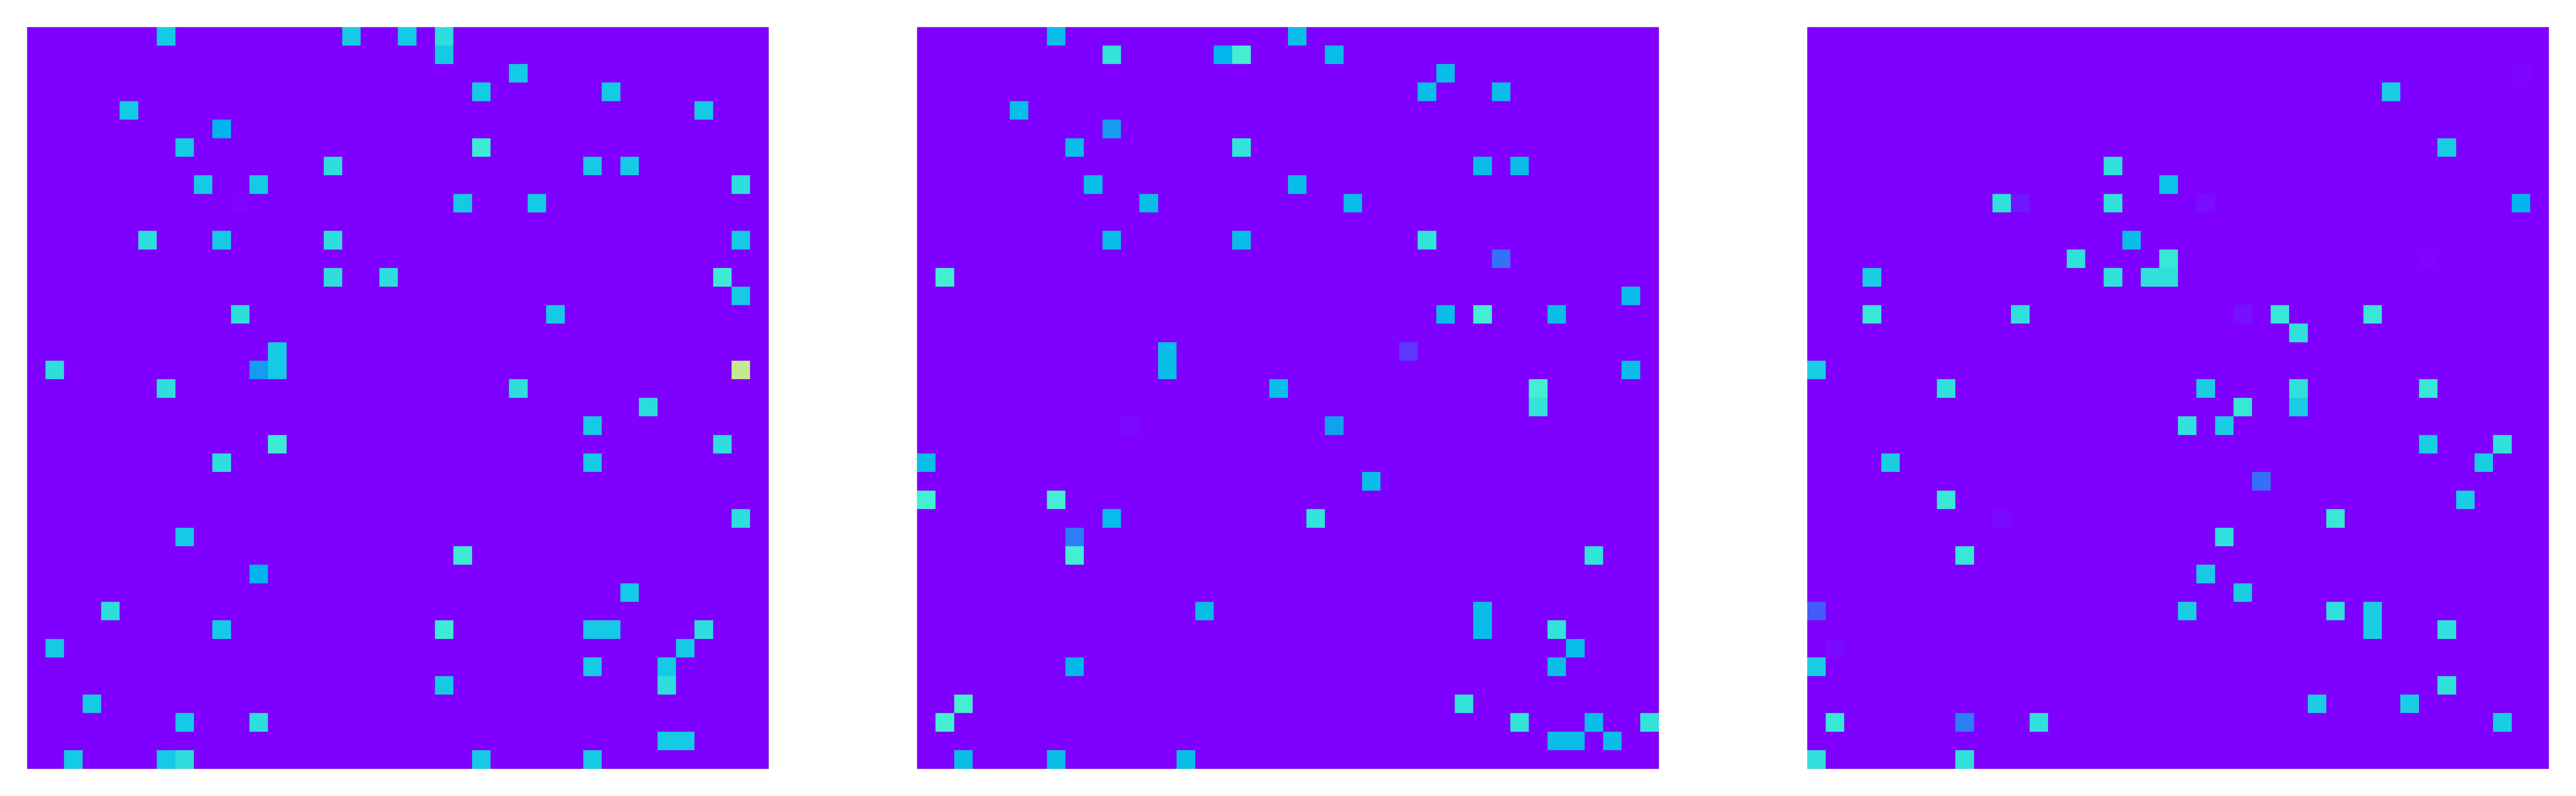

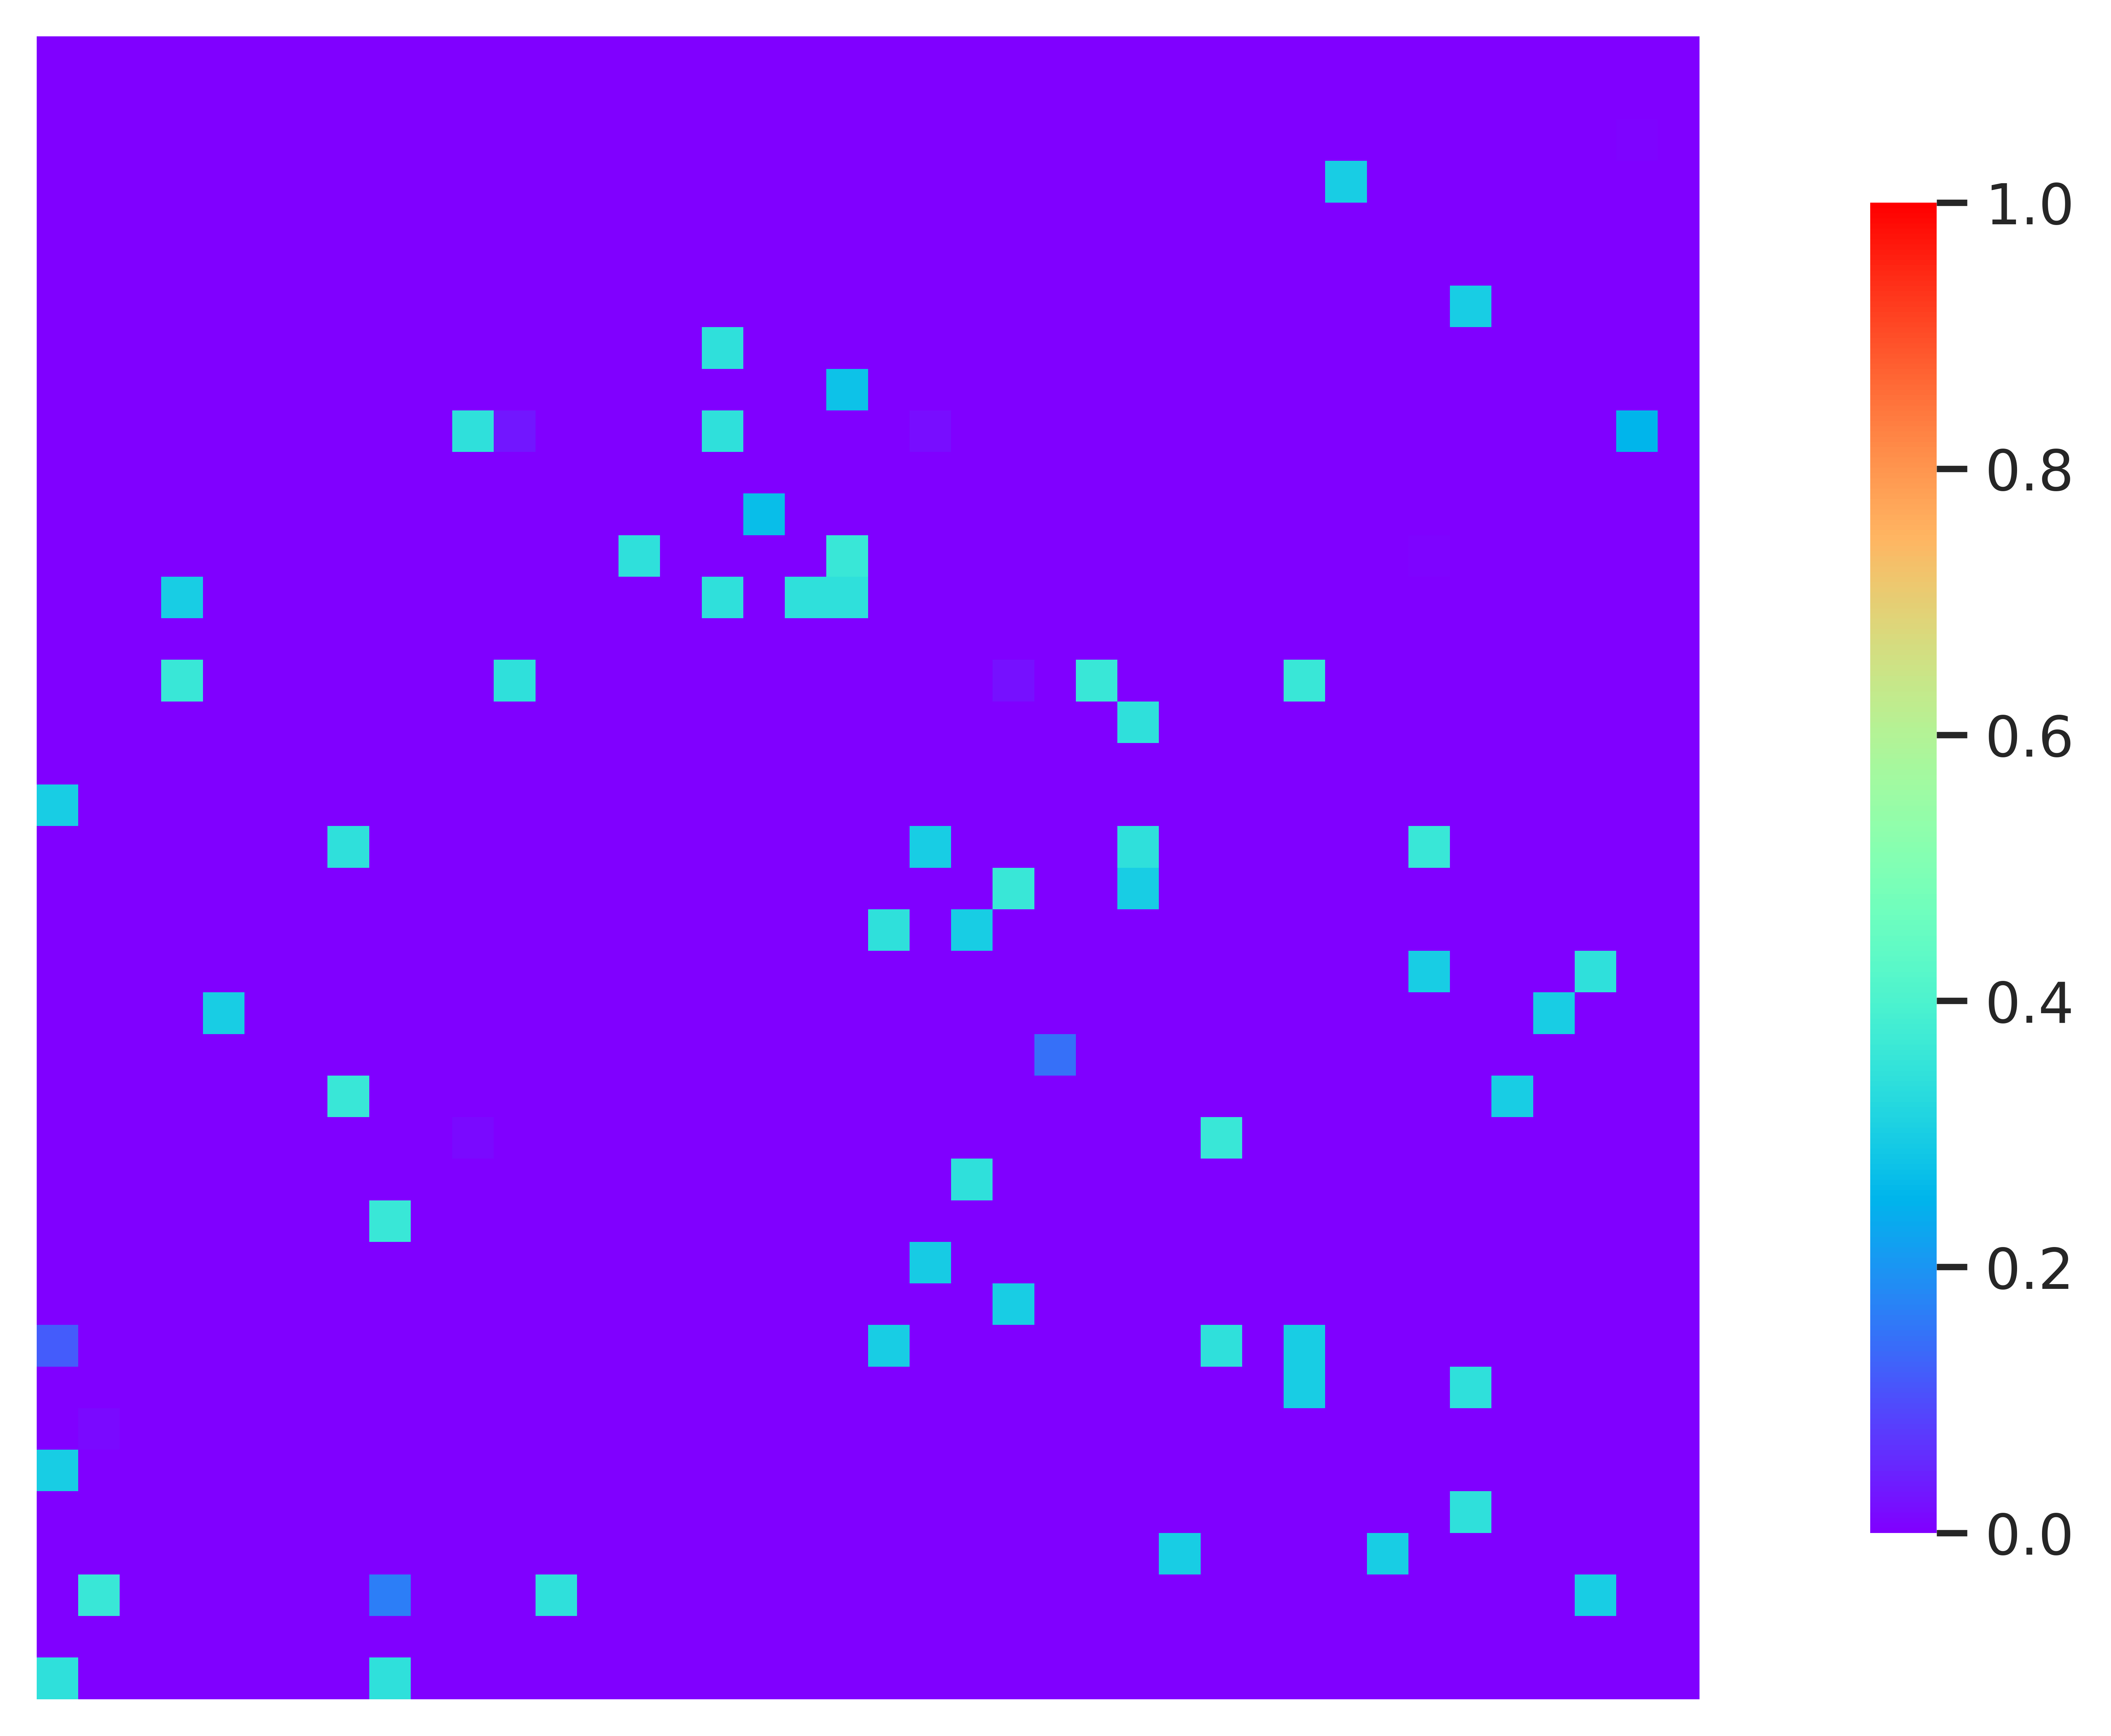

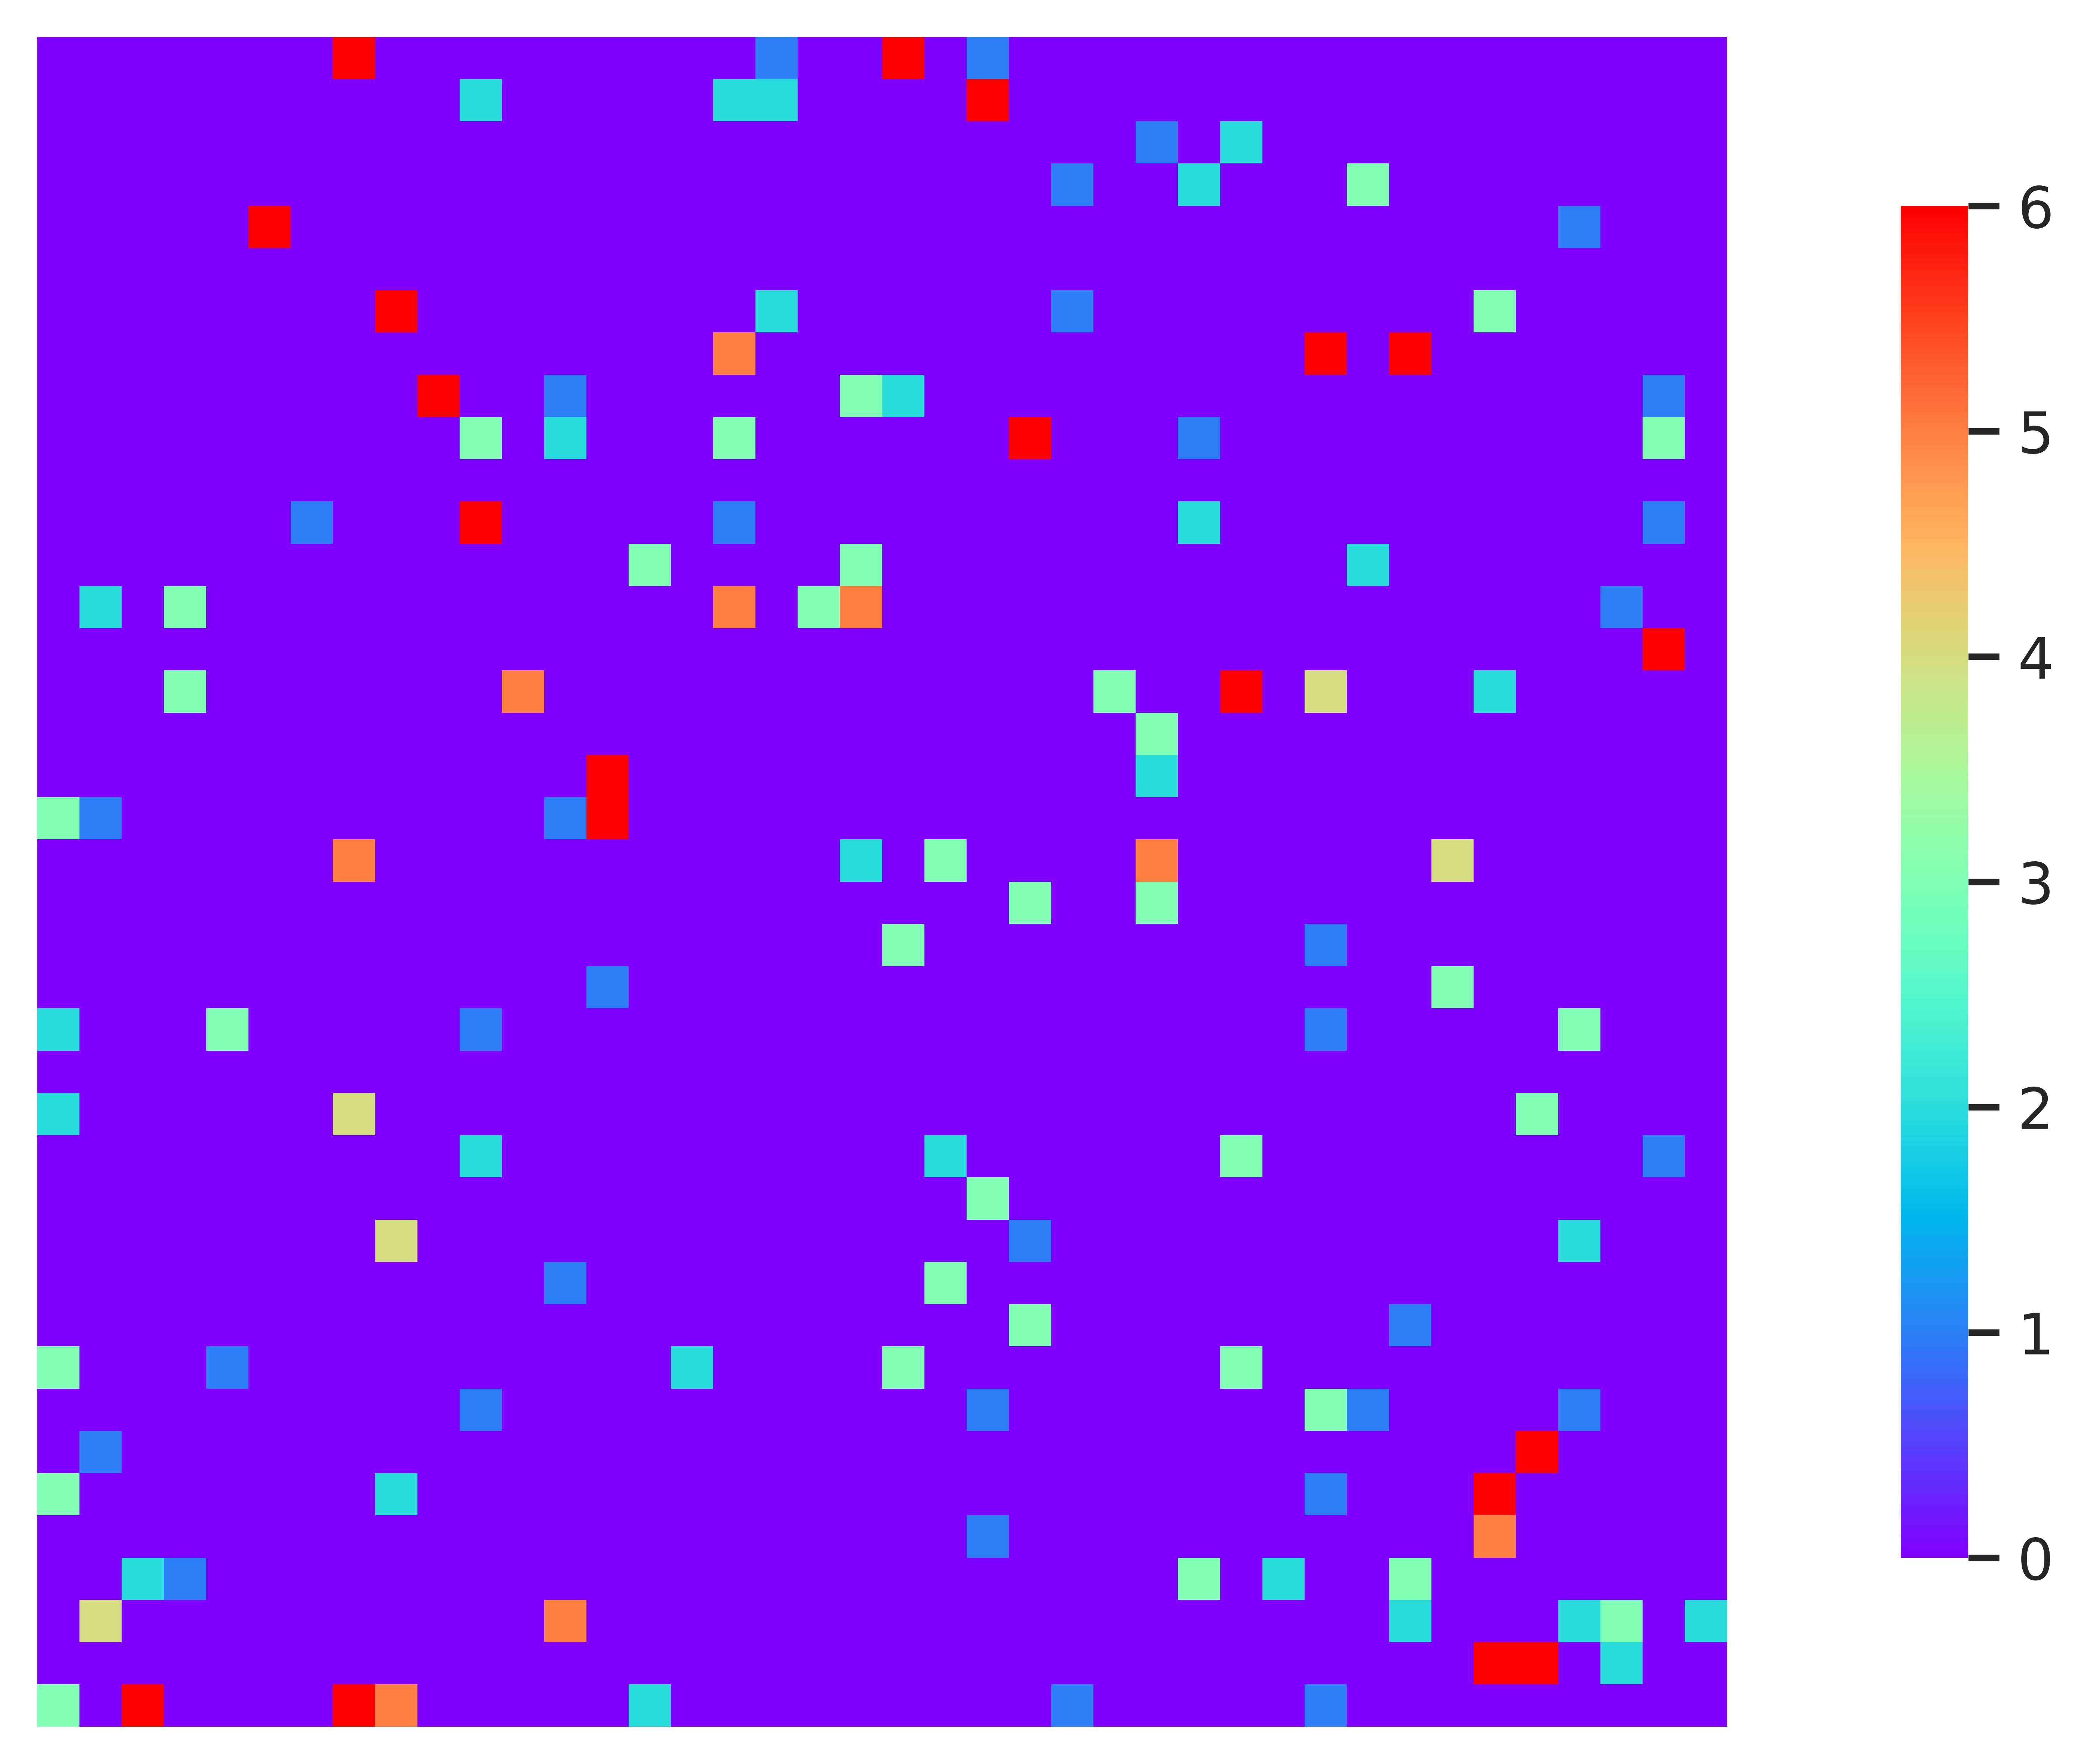

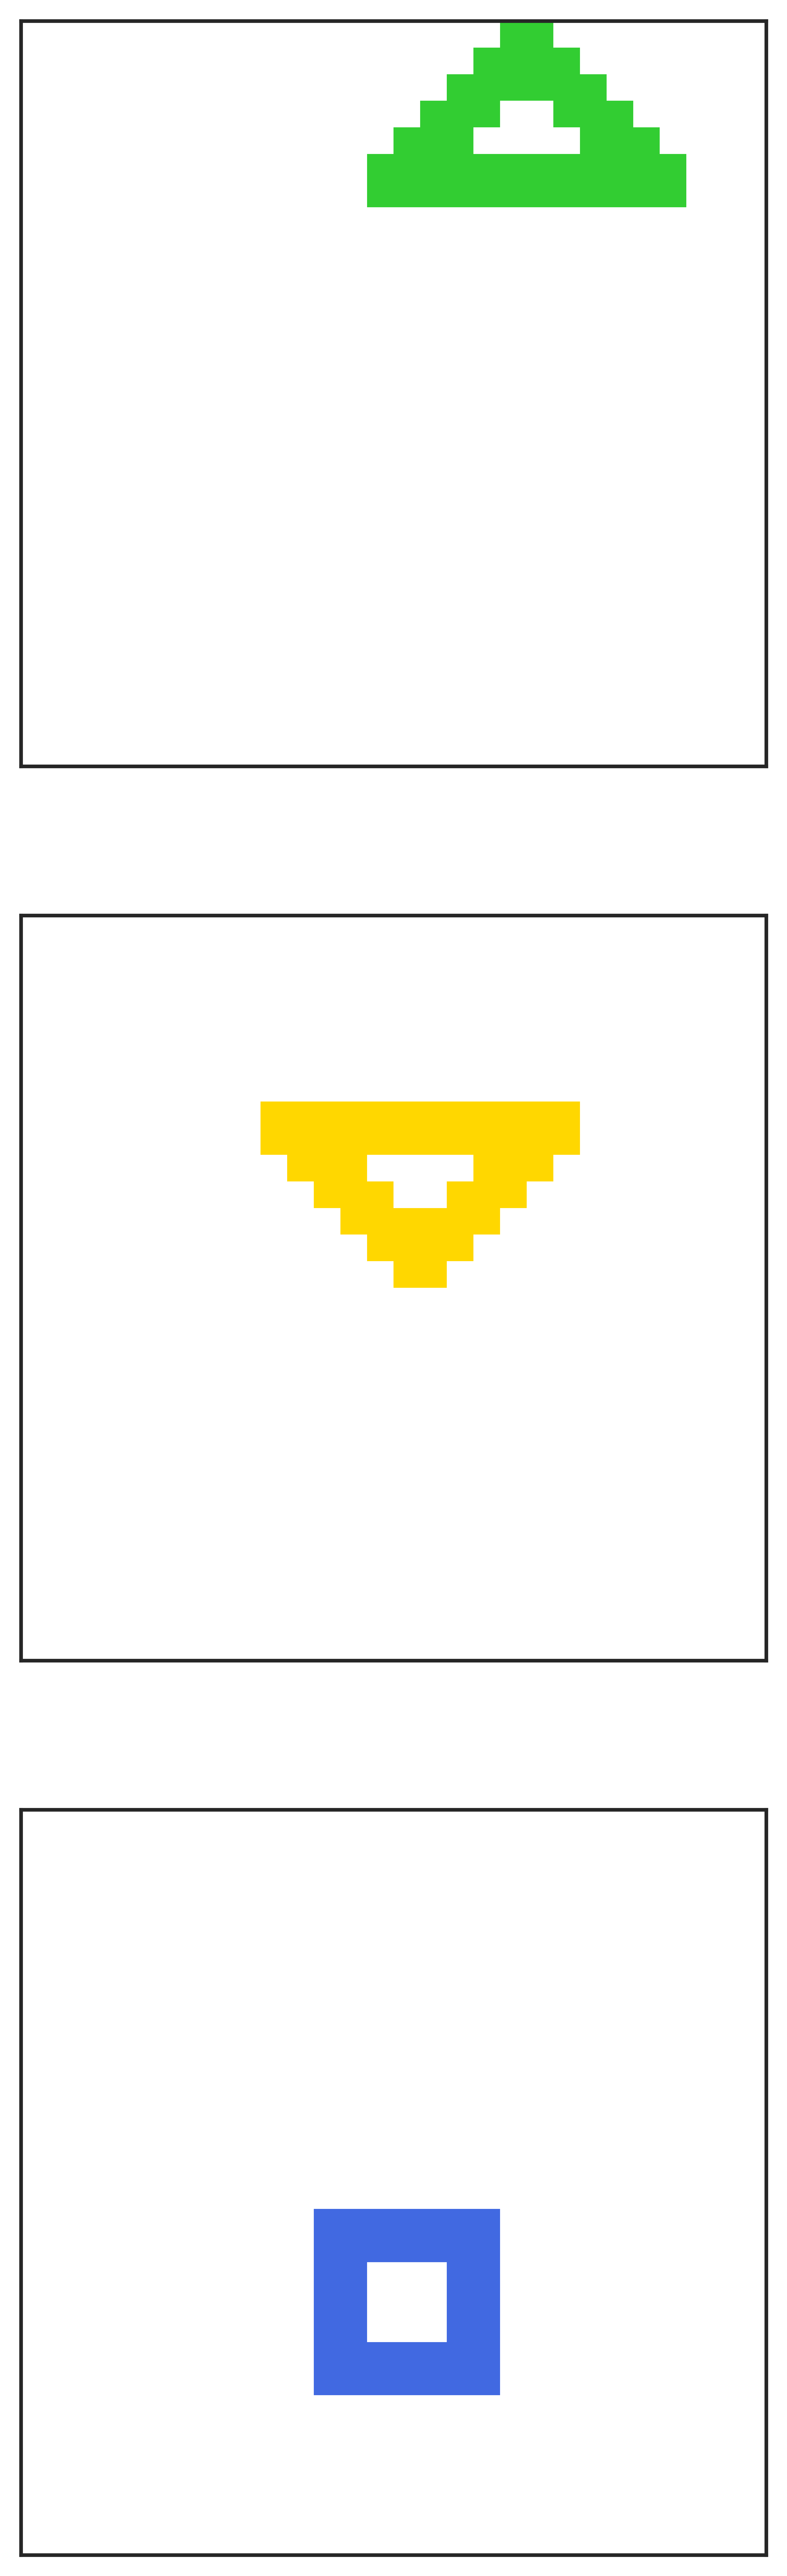

In [15]:
square = np.array(
    [[1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 0, 0, 0, 1, 1],
     [1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1]])

triangle = np.array(
    [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
     [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

shapes = [square, triangle, triangle[::-1, :].copy()]
has_shapes = []
has_shapes_pos = []
print(img.shape)
simple_imgs = []
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        for i in range(len(shapes)):
            shape = shapes[i]
            sy, sx = shape.shape
            region = (slice(y,y+sy), slice(x,x+sx))
            if y + sy > img.shape[0] or x + sx > img.shape[1]:
                continue
            if np.multiply(img[region], shape).sum() == shape.sum():
                has_shapes.append(i)
                tmp_img = np.zeros((img.shape[0], img.shape[1]))
                tmp_img[region] = shape
                simple_imgs.append(tmp_img)
                if i != 0:
                    has_shapes_pos.append([y, x])
                else:
                    has_shapes_pos.append([y, x])

print('has shapes: ', has_shapes)
print('shapes position: ', has_shapes_pos)
plt.figure()
for i in range(len(has_shapes)):
    x = has_shapes_pos[i][0]
    y = has_shapes_pos[i][1]
    idx = x * img.shape[0] + y

pos_feature_neuron_tmp = copy.deepcopy(pos_feature_neuron)
plt.rcParams['figure.figsize'] = (12.0, 6.0) # 单位是inches
plt.figure()
pos_feature_neuron_tmp = pos_feature_neuron_tmp.reshape(-1, hidden_size)
for i in range(len(has_shapes)):
    plt.subplot(1, len(has_shapes), i + 1)
    x = has_shapes_pos[i][0]
    y = has_shapes_pos[i][1]
    idx = x * pos_size + y
    pos_feature_neuron_tmp[idx][idxes[has_shapes[i]]] = 0
    sns.heatmap(pos_feature_neuron_tmp[idx].reshape(40, 40), square=True, xticklabels=False,
                yticklabels=False, cmap='rainbow', cbar=False, vmin=0, vmax=1)
    plt.axis('off')
    print(pos_idxes[idx])
plt.show()

sns.heatmap(pos_feature_neuron_tmp[idx].reshape(40, 40), square=True, xticklabels=False,
                yticklabels=False, cmap='rainbow', cbar=True, cbar_kws={"shrink": 0.8}, vmin=0, vmax=1)
plt.show()

feature_group = np.zeros((hidden_size, ))

for k in range(len(has_shapes)):  # position neuron
    x = has_shapes_pos[k][0]
    y = has_shapes_pos[k][1]
    idx = x * pos_size + y
    for i in range(len(pos_idxes[idx])):
        if feature_group[pos_idxes[idx][i]] == 0:
            feature_group[pos_idxes[idx][i]] = k + 1
        else:
            feature_group[pos_idxes[idx][i]] = 0

for k in range(len(has_shapes)):  # shape neuron
    shape = has_shapes[k]
    for i in range(len(idxes[shape])):  
        feature_group[idxes[shape][i]] = len(has_shapes) + k + 1
plt.figure()
sns.heatmap(feature_group.reshape(40, 40), square=True, xticklabels=False,
                yticklabels=False, cmap='rainbow', cbar=True, cbar_kws={"shrink": 0.8})
plt.show()

name = ['limegreen', 'gold', 'royalblue']
plt.figure(figsize=(48, 16))
for i in range(len(simple_imgs)):
    plt.subplot(len(simple_imgs), 1, i + 1)
    colors = ['white', name[i]] 
    cmap = mpl.colors.ListedColormap(colors)
    plt.imshow(simple_imgs[i], cmap=cmap)
    plt.axis('on')
    plt.box('on')
    frame = plt.gca()

    frame.axes.get_yaxis().set_visible(False)
    frame.axes.get_xaxis().set_visible(False)
plt.show()

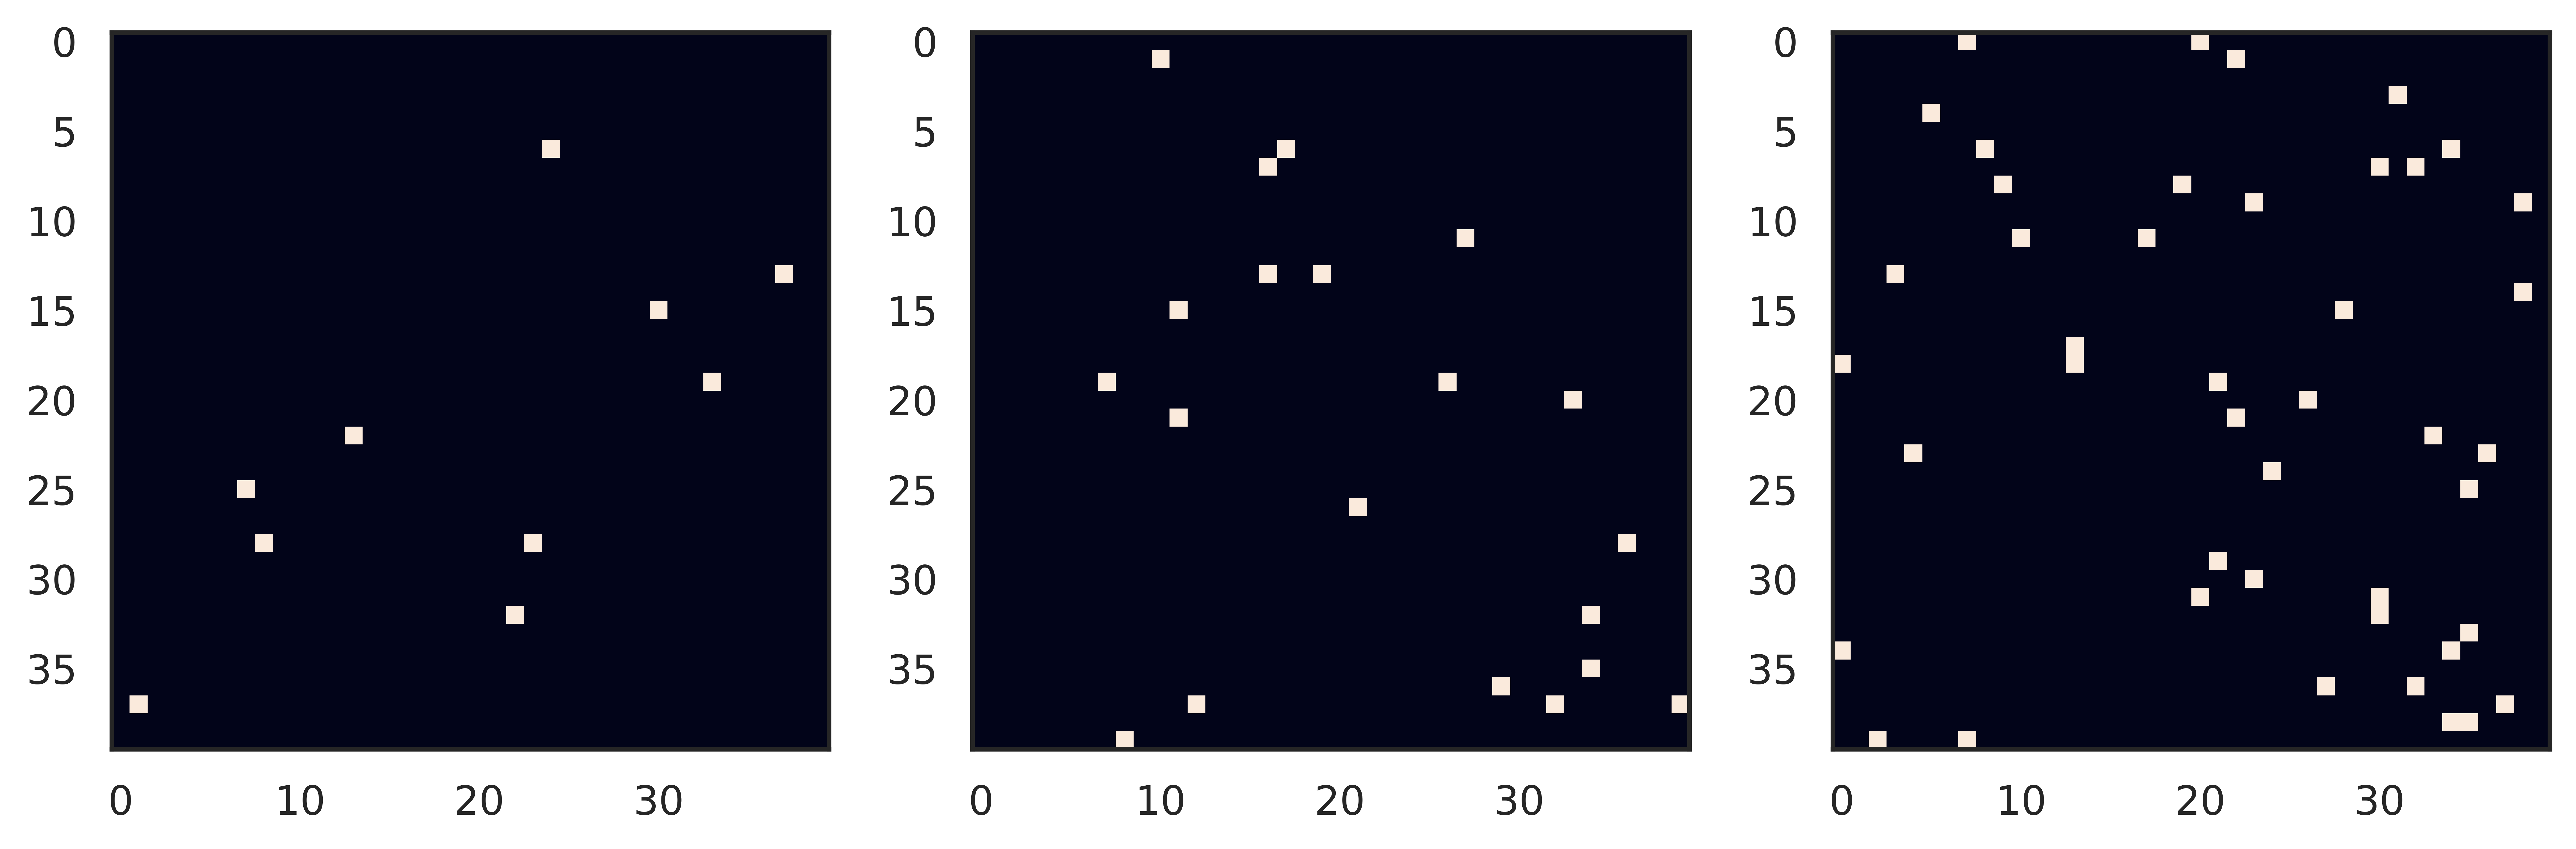

[[264, 557, 630, 793, 893, 1007, 1128, 1143, 1302, 1481], [50, 257, 296, 467, 536, 539, 611, 767, 786, 833, 851, 1061, 1156, 1314, 1434, 1469, 1492, 1512, 1519, 1568], [7, 20, 62, 151, 165, 248, 274, 310, 312, 329, 339, 383, 398, 450, 457, 523, 598, 628, 693, 720, 733, 781, 826, 862, 913, 924, 956, 984, 1035, 1181, 1223, 1260, 1270, 1310, 1355, 1360, 1394, 1467, 1472, 1517, 1554, 1555, 1562, 1567]]
[[264, 1481, 1128, 557, 1007, 630, 1143, 1302, 793, 893], [833, 257, 1156, 786, 467, 851, 1492, 536, 1434, 539, 1568, 1314, 611, 1061, 296, 1512, 1519, 50, 1469, 767], [7, 523, 1035, 781, 398, 913, 274, 1554, 20, 1555, 151, 1562, 924, 1181, 1310, 1567, 165, 693, 310, 312, 826, 1467, 956, 62, 1472, 450, 1223, 329, 457, 1355, 720, 1360, 339, 598, 984, 733, 862, 1260, 1517, 1394, 628, 1270, 248, 383]]
has shapes: 1
has shapes: 2
has shapes: 0
[[264, 557, 1302, 1143, 893], [833, 1314, 257, 1156, 1061, 1512, 1519, 50, 467, 1469], [523, 1035, 781, 398, 913, 274, 151, 924, 1181, 1310, 826, 1467, 95

<Figure size 12000x6000 with 0 Axes>

In [16]:
candidate_pos_neuron = []
plt.figure()
for i in range(len(simple_imgs)):
    x = simple_imgs[i].copy()
    x = torch.tensor(x.reshape(1, -1), dtype=torch.float32).to(device)
    out, spikes, mem = net(x)
    spikes = spikes.cpu().detach().numpy().reshape(-1,)
    plt.subplot(1, len(simple_imgs), i + 1)
    plt.imshow(spikes.reshape(40, 40))
    candidate_pos_neuron.append(list(np.where(spikes > 0)[0]))
plt.show()

print(candidate_pos_neuron)
for i in range(0, len(candidate_pos_neuron)):
    union_neuron_set = []
    for j in range(0, len(candidate_pos_neuron)):
        if j == i:
            continue
        union_neuron_set = list(set(union_neuron_set).union(set(candidate_pos_neuron[i]).intersection(set(candidate_pos_neuron[j]))))
    for j in range(0, len(candidate_pos_neuron)):
        candidate_pos_neuron[j] = list(set(candidate_pos_neuron[j]).difference(set(union_neuron_set)))
print(candidate_pos_neuron)

shape_feature_neuron_sets = []
pos_feature_neuron_sets = []
for i in range(len(candidate_pos_neuron)):
    print('has shapes:', has_shapes[i])
    # shape_feature_neuron_set = list(set(idxes[has_shapes[i]]).intersection(set(candidate_pos_neuron[i])))
    shape_feature_neuron_set = idxes[has_shapes[i]]
    pos_feature_neuron_set = pos_idxes[has_shapes_pos[i][0] * pos_size + has_shapes_pos[i][1]]
    pos_feature_neuron_set = list(set(pos_feature_neuron_set).intersection(set(candidate_pos_neuron[i])))
    for j in range(len(idxes)):
        pos_feature_neuron_set = list(set(pos_feature_neuron_set).difference(set(idxes[j])))
    pos_feature_neuron_sets.append(pos_feature_neuron_set)
#     pos_feature_neuron_sets.append(candidate_pos_neuron[i])
    shape_feature_neuron_sets.append(list(shape_feature_neuron_set))
print(pos_feature_neuron_sets)
print(shape_feature_neuron_sets)
for i in range(len(pos_feature_neuron_sets)):
    print(len(pos_feature_neuron_sets[i]))
for i in range(len(shape_feature_neuron_sets)):
    print(len(shape_feature_neuron_sets[i]))

plt.figure()

/home/cbicr-z/.conda/envs/BindNET/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/cbicr-z/.conda/envs/BindNET/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/cbicr-z/.conda/envs/BindNET/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


<Figure size 12000x6000 with 0 Axes>

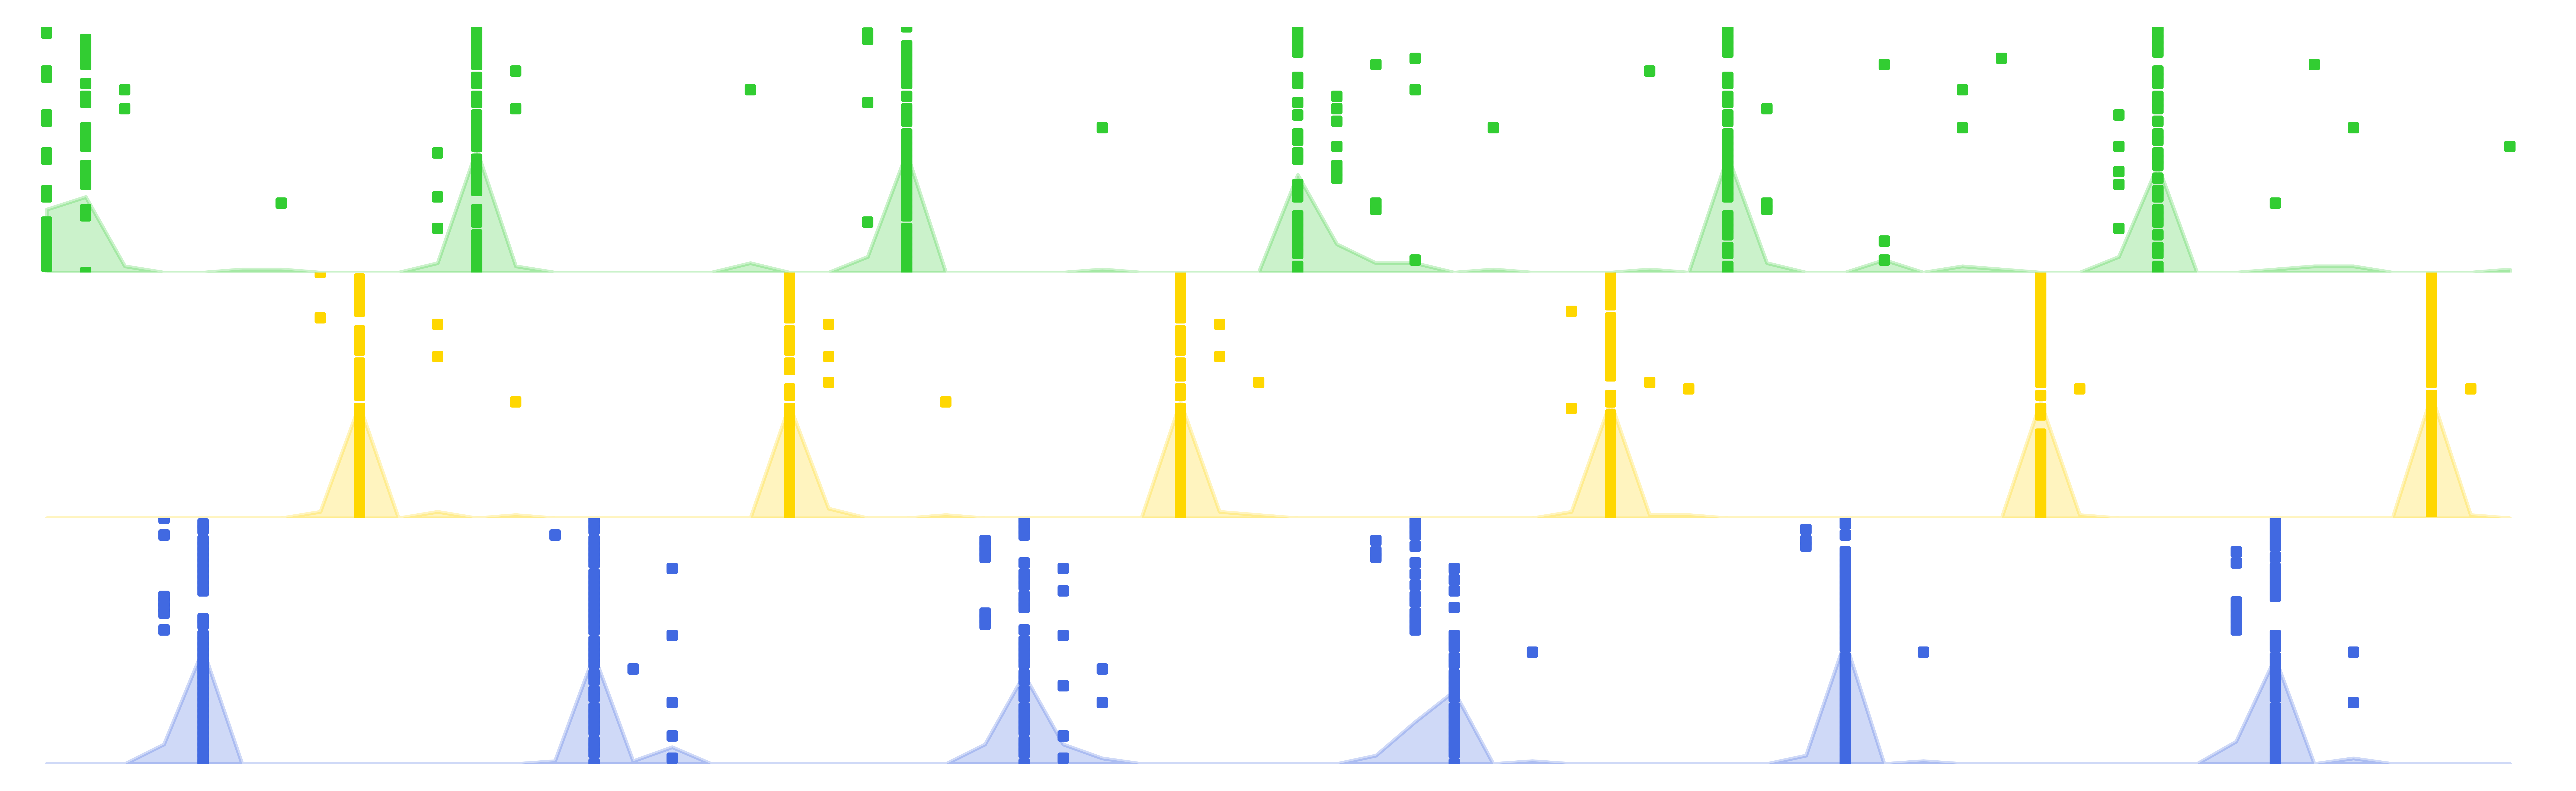

<Figure size 12000x12000 with 0 Axes>

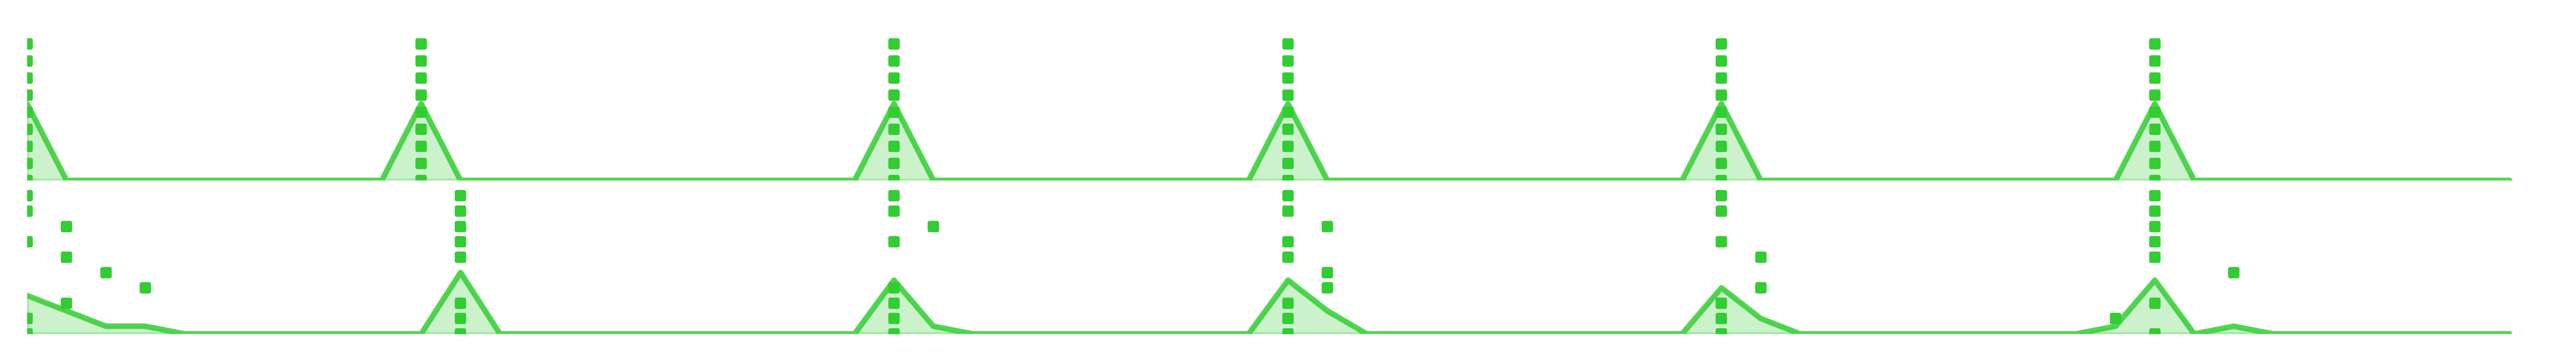

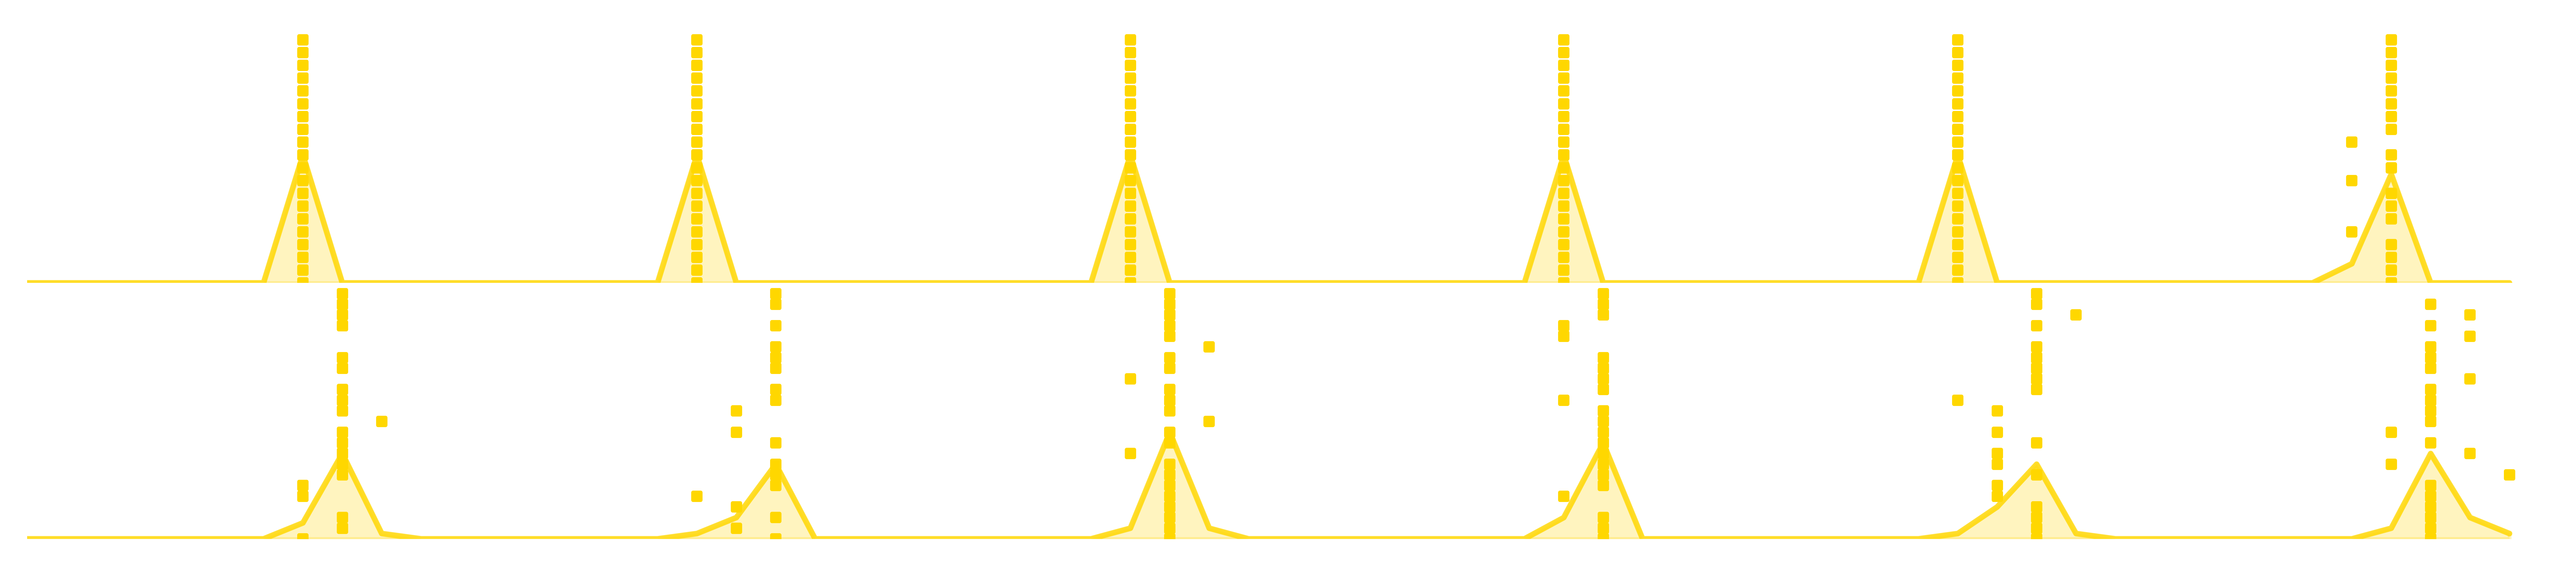

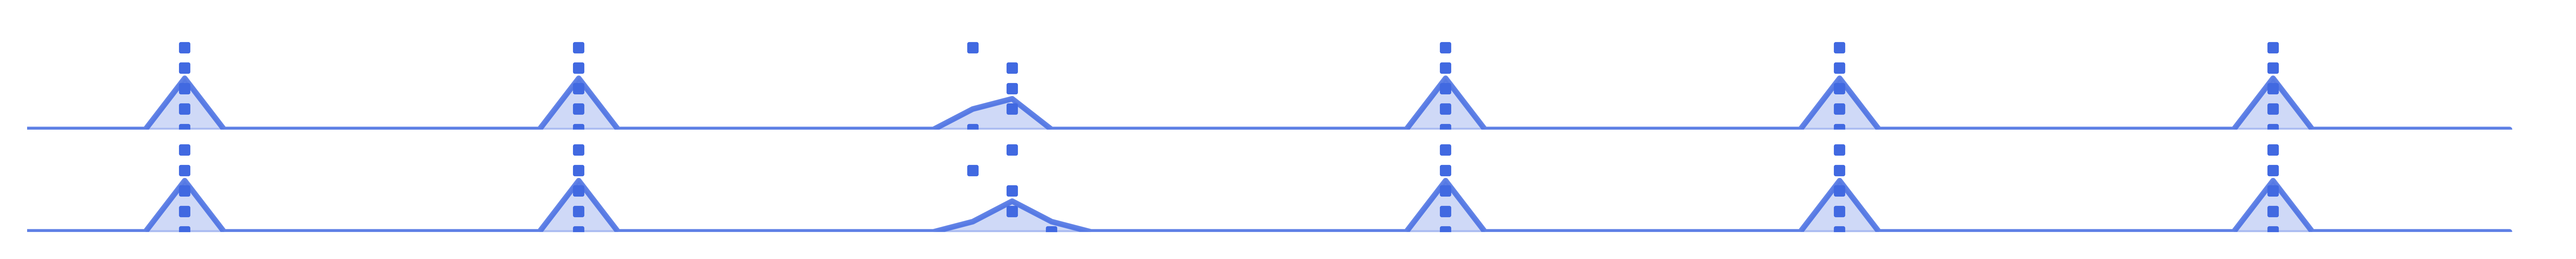

In [17]:
def draw_spike_rasters(spike_record, label, k, color):
    iter = spike_record.shape[0]
    T = spike_record.shape[1]
    spike_record_1d = copy.deepcopy(spike_record.reshape(iter,T,-1))
    size = spike_record_1d.shape[2]
    spike_record_1d = spike_record_1d.reshape(-1, size)

    tmp_idx = np.where(label.reshape(-1) == k)[0]
    spike_record_1d = spike_record_1d[:, tmp_idx]
        
    def get_scatter_data(spk):
        imx = []
        imt = []
        # print("len(spk)[note:win = 32]:", len(spk))
        for i in range(len(spk)):
            for j in range(len(spk[i])):
                if spk[i][j] > 0:
                    imx.append(j)
                    imt.append(i)
        return imx, imt
    
    imx, imt = get_scatter_data(spike_record_1d)
    plt.scatter(imt, imx, alpha=1, s=4, c=color, marker='s')#, edgecolor='w', linewidth=0.05)
#     plt.savefig('./' + name + 'spike_raster.png')
    
def labeled_synchrony_measure(spk, label, back=2, num=2): # low level only
    spk_for_raster = copy.deepcopy(spk)
    K = np.max(label)
    sizex = spk.shape[2]
    sizey = spk.shape[3]
    spk = spk[-back:,:,:,:]
    spk = spk.reshape(-1,sizex,sizey)
    T = spk.shape[0]
    name = ['limegreen', 'gold', 'royalblue', 'coral', 'forestgreen', 'powderblue', 'red','blue','green','yellow','purple','orange','pink','silver','snow','teal','navy','gray']
    groups = np.zeros((int(K),spk.shape[0],spk.shape[1],spk.shape[2])) # K,T,W,H
    selected = np.zeros((int(K),spk.shape[0],num)) # K,T,num
    for t in range(spk.shape[0]):
        for idx in range(spk.shape[1]):
            for idy in range(spk.shape[2]):
                if spk[t,idx,idy]>0:
                    k = int(label[idx, idy])
                    #print(k,t,idx,idy)
                    groups[k-1,t,idx,idy]=1

    for k in range(int(K)):
        id_pol = np.where(groups.sum(1)[k,:,:]>0)
        idx_tmp = np.random.choice(np.arange(len(id_pol[0])),size = num, replace=False)
        selected[k,:,:] = groups[k,:,id_pol[0][idx_tmp],id_pol[1][idx_tmp]].T

    groups = groups.sum(axis=(2, 3))
    t_axis = np.arange(1, T+1)

    plt.rcParams['figure.figsize'] = (12.0, 12.0) # 单位是inches
    plt.figure()
    for k in range(int(K)):
        plt.subplot(K+1+num, 1, k+1)
#         plt.bar(t_axis - 1, groups[k,:], color = name[k], alpha=0.4)
#         plt.plot(t_axis - 1, groups[k, :] * 0.5, color=name[k], alpha=0.8)
        plt.fill_between(t_axis - 1, 0, groups[k, :] * 0.5, color=name[k], alpha=.25)
        draw_spike_rasters(spk_for_raster[-back:], label, k+1, color=name[k])
        plt.ylim([0, groups[k, :].max()])
        plt.xlim([-0.5, t_axis[-1]])
        ax = plt.gca() # 获取当前的axes
        ax.spines['bottom'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.subplots_adjust(wspace=0,hspace=0)  # 将高度和宽度百分比缩小到零
#     plt.subplot(K+1+num, 1, K+1)
#     #print(groups[0,:])
#     tmp = np.zeros_like(groups[0, :])
#     print(tmp.shape)
#     for k in range(int(K)):
#         tmp += groups[k, :]
#     plt.plot(t_axis - 1, tmp, color='k')
#     plt.xlim([-0.5, t_axis[-1]])
#     plt.ylim([-2, groups[k, :].max() * 1.1])
#     ax = plt.gca()
#     ax.spines['top'].set_color('none')
#     ax.spines['right'].set_color('none')

def draw_spike_rasters_pos(spike_record, k, color):
    """
    k: 第k个形状
    """
    iter = spike_record.shape[0]
    T = spike_record.shape[1]
    spike_record_1d = copy.deepcopy(spike_record.reshape(iter, T, -1))
    size = spike_record_1d.shape[2]
    spike_record_1d = spike_record_1d.reshape(-1, size)

    tmp_idx = pos_feature_neuron_sets[k]
    spike_record_1d = spike_record_1d[:, tmp_idx]
        
    def get_scatter_data(spk):
        imx = []
        imt = []
        # print("len(spk)[note:win = 32]:", len(spk))
        for i in range(len(spk)):
            for j in range(len(spk[i])):
                if spk[i][j] > 0:
                    imx.append(j)
                    imt.append(i)
        return imx, imt
    
    imx, imt = get_scatter_data(spike_record_1d)
    plt.scatter(imt, imx, alpha=1, s=4, c=color, marker='s')#, edgecolor='w', linewidth=0.5)

    spike_record_1d_sum = spike_record_1d.sum(axis=1)
    plt.plot(range(spike_record_1d.shape[0]), spike_record_1d_sum * 0.5, color=color, alpha=0.8)
    plt.fill_between(range(spike_record_1d.shape[0]), 0, spike_record_1d_sum * 0.5, color=color, alpha=.25)

    plt.xlim([0, spike_record_1d.shape[0]])
    plt.ylim([0, len(tmp_idx)])

def draw_spike_rasters_shape(spike_record, k, color):
    """
    k: 第k个形状
    """
    iter = spike_record.shape[0]
    T = spike_record.shape[1]
    spike_record_1d = copy.deepcopy(spike_record.reshape(iter, T, -1))
    size = spike_record_1d.shape[2]
    spike_record_1d = spike_record_1d.reshape(-1, size)

    tmp_idx = shape_feature_neuron_sets[k]
    spike_record_1d = spike_record_1d[:, tmp_idx]
        
    def get_scatter_data(spk):
        imx = []
        imt = []
        # print("len(spk)[note:win = 32]:", len(spk))
        for i in range(len(spk)):
            for j in range(len(spk[i])):
                if spk[i][j] > 0:
                    imx.append(j)
                    imt.append(i)
        return imx, imt
    
    imx, imt = get_scatter_data(spike_record_1d)
    plt.scatter(imt, imx, alpha=1, s=4, c=color, marker='s')#, edgecolor='w', linewidth=0.5)
    spike_record_1d_sum = spike_record_1d.sum(axis=1)
    plt.plot(range(spike_record_1d.shape[0]), spike_record_1d_sum * 0.5, color=color, alpha=0.8)
    plt.fill_between(range(spike_record_1d.shape[0]), 0, spike_record_1d_sum * 0.5, color=color, alpha=.25)
    plt.xlim([0, spike_record_1d.shape[0]])
    plt.ylim([0, len(tmp_idx)])

figsizes = [(12.0, 1.0), (12.0, 1.5), (12.0, 2.5)]
name = ['limegreen', 'gold', 'royalblue', 'coral', 'forestgreen', 'powderblue', 'red','blue','green','yellow','purple','orange','pink','silver','snow','teal','navy','gray']    
sns.set_theme(style='white')

back = 2
labeled_synchrony_measure(spk[0], label, num=6, back=back)

plt.figure()
high_index = [2, 0, 1]
for k in [1, 2, 0]: #range(len(has_shapes)):
    plt.rcParams['figure.figsize'] = figsizes[k] # 单位是inches
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    draw_spike_rasters_shape(encoding[0][-back:], k=k, color=name[high_index[k]])
    ax = plt.gca() # 获取当前的axes
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
#     plt.ylim([0, 20])
#     plt.ylabel('shape         ', fontdict={'color':name[k]}, rotation=0)
    
    plt.subplot(2, 1, 2)
    draw_spike_rasters_pos(encoding[0][-back:], k=k, color=name[high_index[k]])
    ax = plt.gca() # 获取当前的axes
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.set_xticks([])
    ax.set_yticks([])
#     plt.ylabel('position         ', fontdict={'color':name[k]}, rotation=0)
#     plt.show()
    plt.subplots_adjust(wspace=0,hspace=0)  # 将高度和宽度百分比缩小到零
    fig.savefig('./fig6/hidden_feature_binding_' + str(k) + '.png')
#     plt.ylim([0, 20])
plt.subplots_adjust(wspace=0, hspace=0)  # 将高度和宽度百分比缩小到零
plt.show()